<a href="https://colab.research.google.com/github/caxios/MLDS/blob/main/Seq2Seq_Stock_Clustering_RNN_based_time_series_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code assits by AI(comments, data-preprocessing, visualizations)
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Each section is independent. It means you better run each section in different runtime

# RNN-KMean

In [2]:
# =============================================================================
# 1. Encoder - Extracts features from price sequences
# =============================================================================
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, x):
        # x: (Batch, Seq_Len, Input_Size)
        # h_n: (Num_Layers, Batch, Hidden_Size)
        _, h_next = self.rnn(x)
        return h_next  # Context Vector (hidden state)

# =============================================================================
# 2. Decoder - Predicts future prices
# =============================================================================
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_prev):
        out, h_next = self.rnn(x, h_prev)
        pred = self.fc(out)
        return pred, h_next

# =============================================================================
# 3. Seq2Seq Model with encode_only for clustering
# =============================================================================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len

    def forward(self, x, target=None):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        context_vector = self.encoder(x)
        h_prev = context_vector
        decoder_input = torch.zeros(batch_size, 1, output_size).to(x.device)
        outputs = []
        for t in range(self.target_len):
            pred, h_next = self.decoder(decoder_input, h_prev)
            outputs.append(pred)
            decoder_input = pred
            h_prev = h_next
        outputs = torch.cat(outputs, dim=1)
        return outputs

    def encode_only(self, x):
        """
        Extract encoder's context vector for clustering.
        Returns: (Batch, n_layers * hidden_size) flattened vector
        """
        context_vector = self.encoder(x)  # (n_layers, batch, hidden_size)
        batch_size = x.size(0)
        return context_vector.transpose(0, 1).reshape(batch_size, -1)

In [3]:
# =============================================================================
# 4. Data Preparation - Multiple Stocks
# =============================================================================
# List of stock tickers to cluster
tickers = [
    # Tech stocks
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'TSLA',
    # Financial stocks
    'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C',
    # Healthcare stocks
    'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
    # Consumer stocks
    'WMT', 'AMZN', 'HD', 'NKE', 'MCD', 'SBUX',
    # Energy stocks
    'XOM', 'CVX', 'COP', 'SLB',
]

period = '1y'
sequence_length = 30
target_len = 5

print(f"Fetching data for {len(tickers)} stocks...")

# Store processed data for each stock
stock_data = {}
all_sequences = []
all_targets = []
stock_indices = []  # Track which sequences belong to which stock

for ticker in tickers:
    try:
        data = yf.Ticker(ticker).history(period=period)
        if len(data) < sequence_length + target_len:
            print(f"  Skipping {ticker}: Not enough data")
            continue

        close_prices = data['Close'].values.reshape(-1, 1)

        # Normalize each stock's prices individually
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)

        # Create sequences for this stock
        X_list = []
        y_list = []
        for i in range(len(scaled_data) - sequence_length - target_len + 1):
            X_list.append(scaled_data[i:i + sequence_length])
            y_list.append(scaled_data[i + sequence_length:i + sequence_length + target_len])

        if len(X_list) > 0:
            stock_data[ticker] = {
                'scaler': scaler,
                'X': np.array(X_list),
                'y': np.array(y_list),
                'raw_prices': close_prices
            }
            all_sequences.extend(X_list)
            all_targets.extend(y_list)
            stock_indices.extend([ticker] * len(X_list))
            print(f"  {ticker}: {len(X_list)} sequences")
    except Exception as e:
        print(f"  Error fetching {ticker}: {e}")

# Convert to tensors
X = torch.tensor(np.array(all_sequences), dtype=torch.float32)
y = torch.tensor(np.array(all_targets), dtype=torch.float32)

print(f"\nTotal sequences: {X.shape[0]}")
print(f"Sequence shape: {X.shape}")
print(f"Target shape: {y.shape}")

Fetching data for 29 stocks...
  AAPL: 217 sequences
  MSFT: 217 sequences
  GOOGL: 217 sequences
  META: 217 sequences
  NVDA: 217 sequences
  AMD: 217 sequences
  INTC: 217 sequences
  TSLA: 217 sequences
  JPM: 217 sequences
  BAC: 217 sequences
  GS: 217 sequences
  MS: 217 sequences
  WFC: 217 sequences
  C: 217 sequences
  JNJ: 217 sequences
  PFE: 217 sequences
  UNH: 217 sequences
  MRK: 217 sequences
  ABBV: 217 sequences
  WMT: 217 sequences
  AMZN: 217 sequences
  HD: 217 sequences
  NKE: 217 sequences
  MCD: 217 sequences
  SBUX: 217 sequences
  XOM: 217 sequences
  CVX: 217 sequences
  COP: 217 sequences
  SLB: 217 sequences

Total sequences: 6293
Sequence shape: torch.Size([6293, 30, 1])
Target shape: torch.Size([6293, 5, 1])


In [4]:
# =============================================================================
# 5. Model Setup
# =============================================================================
input_size = 1  # Price is 1-dimensional
hidden_size = 64
n_layers = 2
output_size = 1

enc = Encoder(input_size, hidden_size, n_layers)
dec = Decoder(output_size, hidden_size, output_size, n_layers)
model = Seq2Seq(enc, dec, target_len)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# =============================================================================
# 6. Training
# =============================================================================
num_epochs = 100
print(f"\nTraining for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Training complete.\n")


Training for 100 epochs...
Epoch [20/100], Loss: 0.055283
Epoch [40/100], Loss: 0.012356
Epoch [60/100], Loss: 0.008712
Epoch [80/100], Loss: 0.007930
Epoch [100/100], Loss: 0.007556
Training complete.



In [6]:
# =============================================================================
# 7. Extract Encoder Embeddings for Each Stock
# =============================================================================
print("--- Extracting Stock Embeddings ---")

model.eval()
stock_embeddings = {}

with torch.no_grad():
    for ticker, data in stock_data.items():
        X_stock = torch.tensor(data['X'], dtype=torch.float32)

        # Get encoder embeddings for all sequences of this stock
        embeddings = model.encode_only(X_stock).numpy()

        # Aggregate: Use mean embedding to represent the stock's overall pattern
        # You could also use: max, last, or weighted mean
        stock_embedding = embeddings.mean(axis=0)
        stock_embeddings[ticker] = stock_embedding

        print(f"  {ticker}: embedding shape = {stock_embedding.shape}")

# Convert to matrix for clustering
embedding_matrix = np.array(list(stock_embeddings.values()))
ticker_list = list(stock_embeddings.keys())

print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

--- Extracting Stock Embeddings ---
  AAPL: embedding shape = (128,)
  MSFT: embedding shape = (128,)
  GOOGL: embedding shape = (128,)
  META: embedding shape = (128,)
  NVDA: embedding shape = (128,)
  AMD: embedding shape = (128,)
  INTC: embedding shape = (128,)
  TSLA: embedding shape = (128,)
  JPM: embedding shape = (128,)
  BAC: embedding shape = (128,)
  GS: embedding shape = (128,)
  MS: embedding shape = (128,)
  WFC: embedding shape = (128,)
  C: embedding shape = (128,)
  JNJ: embedding shape = (128,)
  PFE: embedding shape = (128,)
  UNH: embedding shape = (128,)
  MRK: embedding shape = (128,)
  ABBV: embedding shape = (128,)
  WMT: embedding shape = (128,)
  AMZN: embedding shape = (128,)
  HD: embedding shape = (128,)
  NKE: embedding shape = (128,)
  MCD: embedding shape = (128,)
  SBUX: embedding shape = (128,)
  XOM: embedding shape = (128,)
  CVX: embedding shape = (128,)
  COP: embedding shape = (128,)
  SLB: embedding shape = (128,)

Embedding matrix shape: (29, 

In [7]:
# =============================================================================
# 8. K-Means Clustering of Stocks
# =============================================================================
print("\n--- K-Means Clustering Results ---")

n_clusters = 4  # Adjust based on how many groups you want
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embedding_matrix)

# Group stocks by cluster
clusters = {i: [] for i in range(n_clusters)}
for ticker, label in zip(ticker_list, labels):
    clusters[label].append(ticker)

# Print clustering results
print(f"\nStocks grouped into {n_clusters} clusters:\n")
for cluster_id, stocks in clusters.items():
    print(f"Cluster {cluster_id}: {stocks}")


--- K-Means Clustering Results ---

Stocks grouped into 4 clusters:

Cluster 0: ['AMD', 'TSLA', 'GS', 'MS', 'C', 'JNJ', 'HD', 'XOM', 'COP']
Cluster 1: ['GOOGL', 'INTC', 'UNH', 'MRK', 'SBUX', 'SLB']
Cluster 2: ['MSFT', 'META', 'MCD']
Cluster 3: ['AAPL', 'NVDA', 'JPM', 'BAC', 'WFC', 'PFE', 'ABBV', 'WMT', 'AMZN', 'NKE', 'CVX']


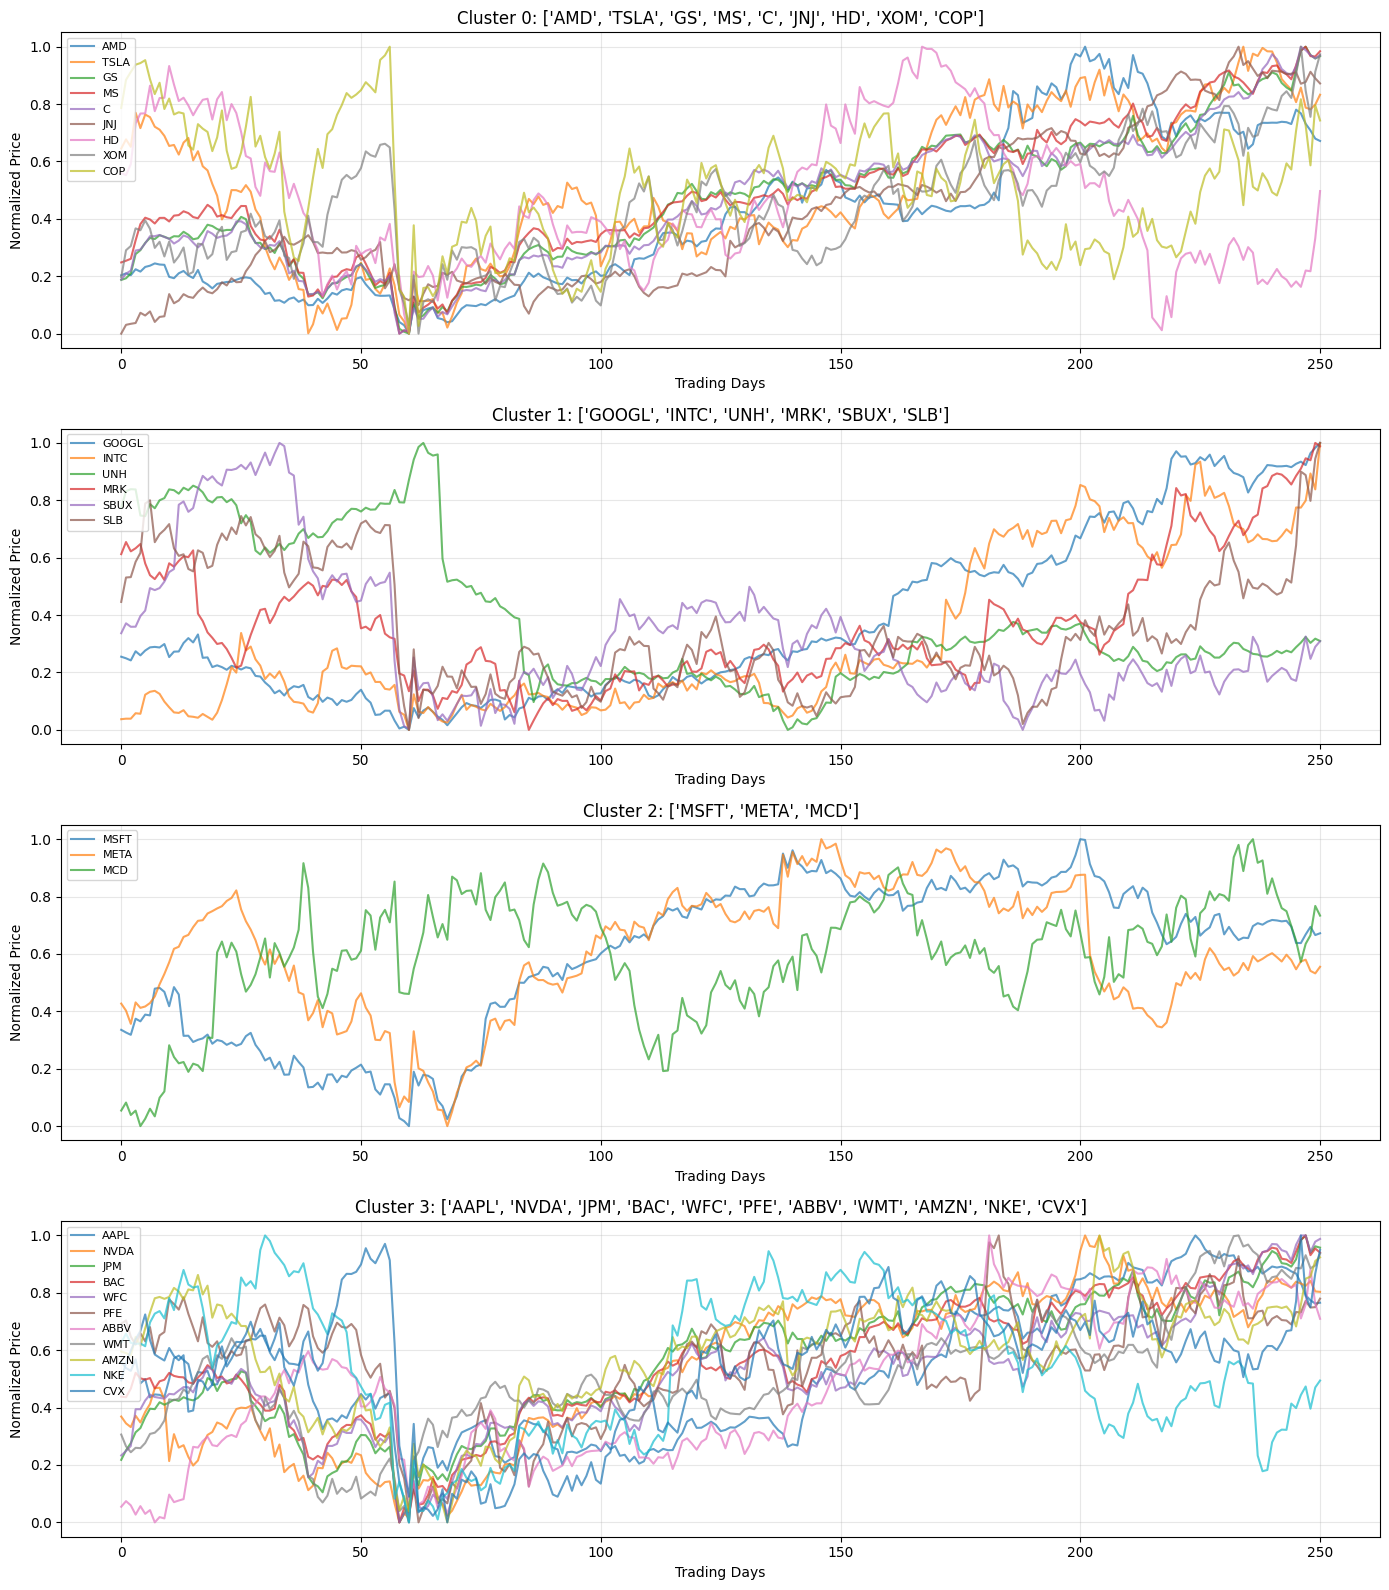


Visualization saved to 'stock_clusters.png'


In [8]:
# =============================================================================
# 9. Visualization - Plot stocks by cluster
# =============================================================================
fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 4 * n_clusters))

for cluster_id in range(n_clusters):
    ax = axes[cluster_id] if n_clusters > 1 else axes
    cluster_stocks = clusters[cluster_id]

    for ticker in cluster_stocks:
        # Normalize prices to 0-1 range for comparison
        prices = stock_data[ticker]['raw_prices'].flatten()
        normalized = (prices - prices.min()) / (prices.max() - prices.min())
        ax.plot(normalized, label=ticker, alpha=0.7)

    ax.set_title(f'Cluster {cluster_id}: {cluster_stocks}')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Normalized Price')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stock_clusters.png', dpi=150)
plt.show()

print("\nVisualization saved to 'stock_clusters.png'")

In [9]:
# =============================================================================
# 10. PLAIN K-MEANS (Without RNN) - For Comparison
# =============================================================================
print("\n" + "="*70)
print("PLAIN K-MEANS CLUSTERING (Without RNN)")
print("="*70)

def extract_simple_features(prices):
    """
    Extract simple statistical features from price series.
    These features capture basic characteristics of price movement.
    """
    prices = prices.flatten()

    # Normalize prices to 0-1 range
    normalized = (prices - prices.min()) / (prices.max() - prices.min() + 1e-8)

    # Daily returns
    returns = np.diff(prices) / (prices[:-1] + 1e-8)

    features = [
        # Basic statistics
        np.mean(returns),           # Average daily return
        np.std(returns),            # Volatility
        np.min(returns),            # Worst day
        np.max(returns),            # Best day

        # Trend indicators
        (prices[-1] - prices[0]) / (prices[0] + 1e-8),  # Total return
        np.mean(normalized[:len(normalized)//2]),  # First half avg
        np.mean(normalized[len(normalized)//2:]),  # Second half avg

        # Momentum
        np.mean(returns[-20:]) if len(returns) >= 20 else np.mean(returns),  # Recent momentum
        np.mean(returns[:20]) if len(returns) >= 20 else np.mean(returns),   # Early momentum

        # Shape of the curve (sample points from normalized curve)
        normalized[0],                          # Start
        normalized[len(normalized)//4],         # Q1
        normalized[len(normalized)//2],         # Mid
        normalized[3*len(normalized)//4],       # Q3
        normalized[-1],                         # End
    ]

    return np.array(features)

# Extract simple features for each stock
print("\nExtracting simple statistical features...")
simple_features = {}
for ticker in stock_data.keys():
    prices = stock_data[ticker]['raw_prices']
    features = extract_simple_features(prices)
    simple_features[ticker] = features
    print(f"  {ticker}: {len(features)} features")

# Convert to matrix
simple_feature_matrix = np.array(list(simple_features.values()))
simple_ticker_list = list(simple_features.keys())

# Normalize features for better clustering
from sklearn.preprocessing import StandardScaler
scaler_features = StandardScaler()
simple_feature_matrix_scaled = scaler_features.fit_transform(simple_feature_matrix)

print(f"\nSimple feature matrix shape: {simple_feature_matrix_scaled.shape}")

# Plain K-Means clustering
kmeans_plain = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_plain = kmeans_plain.fit_predict(simple_feature_matrix_scaled)

# Group stocks by cluster (Plain K-Means)
clusters_plain = {i: [] for i in range(n_clusters)}
for ticker, label in zip(simple_ticker_list, labels_plain):
    clusters_plain[label].append(ticker)

print(f"\nPlain K-Means Clustering Results ({n_clusters} clusters):\n")
for cluster_id, stocks in clusters_plain.items():
    print(f"Cluster {cluster_id}: {stocks}")


PLAIN K-MEANS CLUSTERING (Without RNN)

Extracting simple statistical features...
  AAPL: 14 features
  MSFT: 14 features
  GOOGL: 14 features
  META: 14 features
  NVDA: 14 features
  AMD: 14 features
  INTC: 14 features
  TSLA: 14 features
  JPM: 14 features
  BAC: 14 features
  GS: 14 features
  MS: 14 features
  WFC: 14 features
  C: 14 features
  JNJ: 14 features
  PFE: 14 features
  UNH: 14 features
  MRK: 14 features
  ABBV: 14 features
  WMT: 14 features
  AMZN: 14 features
  HD: 14 features
  NKE: 14 features
  MCD: 14 features
  SBUX: 14 features
  XOM: 14 features
  CVX: 14 features
  COP: 14 features
  SLB: 14 features

Simple feature matrix shape: (29, 14)

Plain K-Means Clustering Results (4 clusters):

Cluster 0: ['GOOGL', 'JPM', 'GS', 'MS', 'WFC', 'C', 'JNJ', 'MRK', 'ABBV', 'WMT', 'XOM']
Cluster 1: ['UNH', 'SBUX', 'SLB']
Cluster 2: ['NVDA', 'AMD', 'INTC', 'TSLA']
Cluster 3: ['AAPL', 'MSFT', 'META', 'BAC', 'PFE', 'AMZN', 'HD', 'NKE', 'MCD', 'CVX', 'COP']



COMPARISON: RNN-KMeans vs Plain K-Means

Ticker   | RNN-KMeans      | Plain K-Means  
---------------------------------------------
AAPL     | Cluster 3       | Cluster 3       ✓
MSFT     | Cluster 2       | Cluster 3       
GOOGL    | Cluster 1       | Cluster 0       
META     | Cluster 2       | Cluster 3       
NVDA     | Cluster 3       | Cluster 2       
AMD      | Cluster 0       | Cluster 2       
INTC     | Cluster 1       | Cluster 2       
TSLA     | Cluster 0       | Cluster 2       
JPM      | Cluster 3       | Cluster 0       
BAC      | Cluster 3       | Cluster 3       ✓
GS       | Cluster 0       | Cluster 0       ✓
MS       | Cluster 0       | Cluster 0       ✓
WFC      | Cluster 3       | Cluster 0       
C        | Cluster 0       | Cluster 0       ✓
JNJ      | Cluster 0       | Cluster 0       ✓
PFE      | Cluster 3       | Cluster 3       ✓
UNH      | Cluster 1       | Cluster 1       ✓
MRK      | Cluster 1       | Cluster 0       
ABBV     | Cluster 3       | Cl

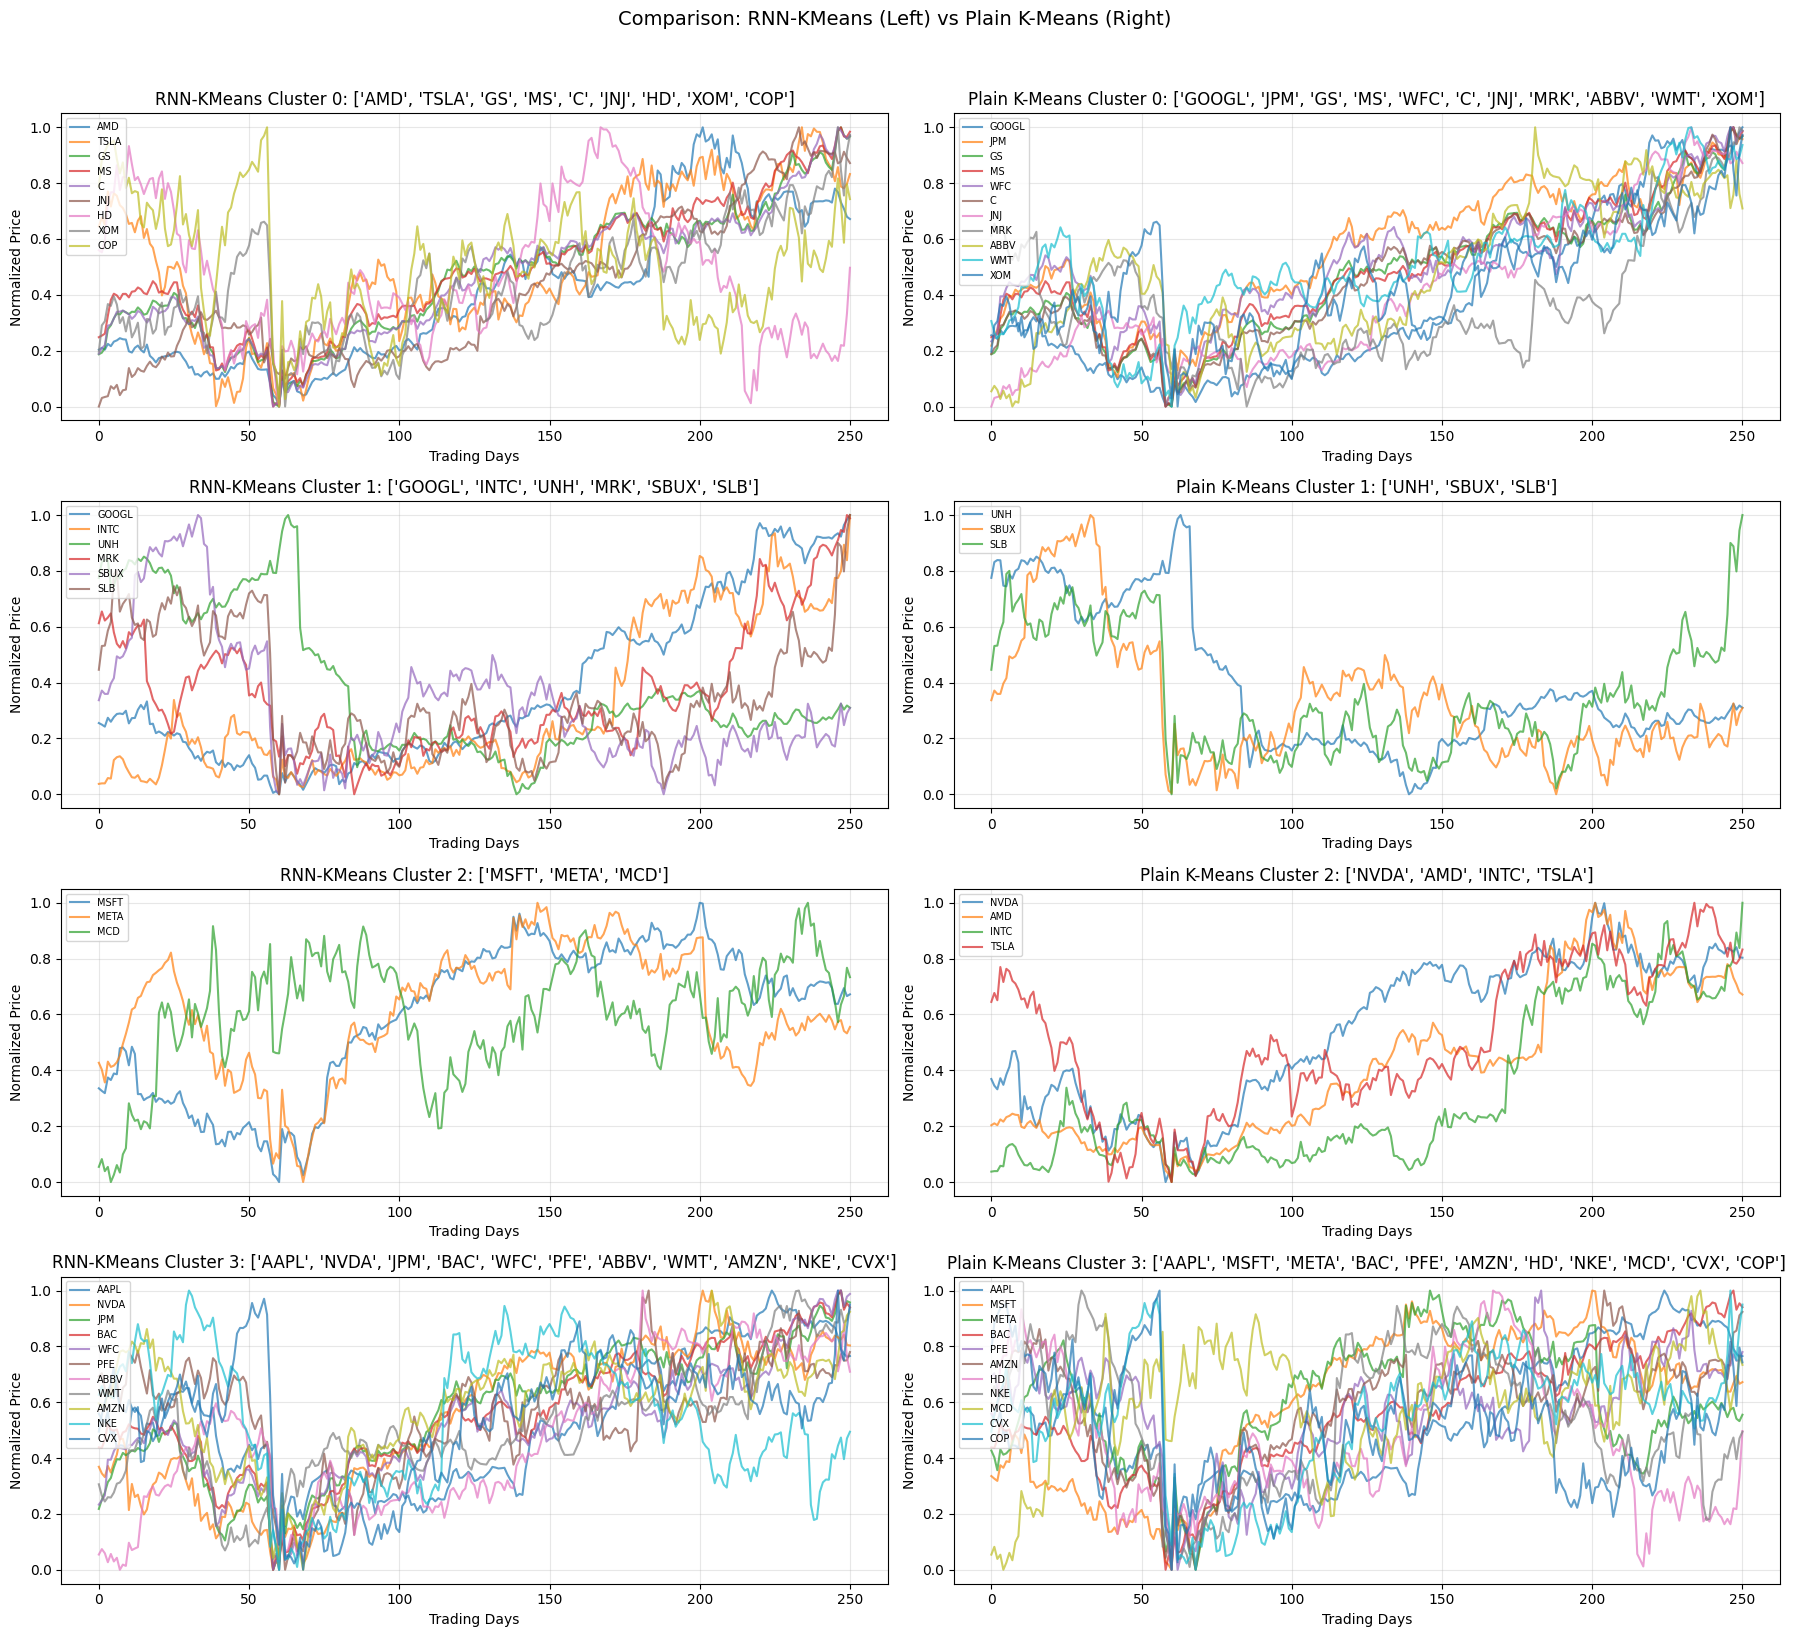


Comparison visualization saved to 'stock_clusters_comparison.png'


In [10]:
# =============================================================================
# 11. COMPARISON: RNN-KMeans vs Plain K-Means
# =============================================================================
print("\n" + "="*70)
print("COMPARISON: RNN-KMeans vs Plain K-Means")
print("="*70)

# Create comparison dataframe
print("\n{:<8} | {:<15} | {:<15}".format("Ticker", "RNN-KMeans", "Plain K-Means"))
print("-" * 45)
for ticker in ticker_list:
    rnn_cluster = labels[ticker_list.index(ticker)]
    plain_cluster = labels_plain[simple_ticker_list.index(ticker)]
    match = "✓" if rnn_cluster == plain_cluster else ""
    print(f"{ticker:<8} | Cluster {rnn_cluster:<7} | Cluster {plain_cluster:<7} {match}")

# Calculate agreement (note: cluster IDs may differ, so we use adjusted rand score)
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(labels, labels_plain)
print(f"\nAdjusted Rand Index (clustering similarity): {ari_score:.4f}")
print("(1.0 = identical clustering, 0.0 = random, negative = worse than random)")

# =============================================================================
# 12. Side-by-Side Visualization
# =============================================================================
fig, axes = plt.subplots(n_clusters, 2, figsize=(18, 4 * n_clusters))

for cluster_id in range(n_clusters):
    # RNN-KMeans (left column)
    ax_rnn = axes[cluster_id, 0] if n_clusters > 1 else axes[0]
    cluster_stocks_rnn = clusters[cluster_id]

    for ticker in cluster_stocks_rnn:
        prices = stock_data[ticker]['raw_prices'].flatten()
        normalized = (prices - prices.min()) / (prices.max() - prices.min())
        ax_rnn.plot(normalized, label=ticker, alpha=0.7)

    ax_rnn.set_title(f'RNN-KMeans Cluster {cluster_id}: {cluster_stocks_rnn}')
    ax_rnn.set_xlabel('Trading Days')
    ax_rnn.set_ylabel('Normalized Price')
    ax_rnn.legend(loc='upper left', fontsize=7)
    ax_rnn.grid(True, alpha=0.3)

    # Plain K-Means (right column)
    ax_plain = axes[cluster_id, 1] if n_clusters > 1 else axes[1]
    cluster_stocks_plain = clusters_plain[cluster_id]

    for ticker in cluster_stocks_plain:
        prices = stock_data[ticker]['raw_prices'].flatten()
        normalized = (prices - prices.min()) / (prices.max() - prices.min())
        ax_plain.plot(normalized, label=ticker, alpha=0.7)

    ax_plain.set_title(f'Plain K-Means Cluster {cluster_id}: {cluster_stocks_plain}')
    ax_plain.set_xlabel('Trading Days')
    ax_plain.set_ylabel('Normalized Price')
    ax_plain.legend(loc='upper left', fontsize=7)
    ax_plain.grid(True, alpha=0.3)

plt.suptitle('Comparison: RNN-KMeans (Left) vs Plain K-Means (Right)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('stock_clusters_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison visualization saved to 'stock_clusters_comparison.png'")

# RNN-Corr

In [ ]:
# =============================================================================
# 1. RNN Encoder Model : Same model as we used in RNN-KMean
# =============================================================================
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, x):
        _, h_next = self.rnn(x)
        return h_next

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_prev):
        out, h_next = self.rnn(x, h_prev)
        return self.fc(out), h_next

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len

    def forward(self, x):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        context_vector = self.encoder(x)
        h_prev = context_vector
        decoder_input = torch.zeros(batch_size, 1, output_size).to(x.device)
        outputs = []
        for t in range(self.target_len):
            pred, h_next = self.decoder(decoder_input, h_prev)
            outputs.append(pred)
            decoder_input = pred
            h_prev = h_next
        return torch.cat(outputs, dim=1)

    def encode_only(self, x):
        """Get flattened encoder embeddings."""
        context = self.encoder(x)
        batch_size = x.size(0)
        return context.transpose(0, 1).reshape(batch_size, -1)

In [ ]:
# =============================================================================
# 2. Data Preparation
# =============================================================================
tickers = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'TSLA',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
    # Consumer
    'WMT', 'AMZN', 'HD', 'NKE', 'MCD', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB',
]

period = '1y'
sequence_length = 30
target_len = 5

print(f"Fetching data for {len(tickers)} stocks...")

stock_data = {}
all_sequences = []
all_targets = []

for ticker in tickers:
    try:
        data = yf.Ticker(ticker).history(period=period)
        if len(data) < sequence_length + target_len:
            print(f"  Skipping {ticker}: Not enough data")
            continue

        close_prices = data['Close'].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)

        X_list = []
        y_list = []
        for i in range(len(scaled_data) - sequence_length - target_len + 1):
            X_list.append(scaled_data[i:i + sequence_length])
            y_list.append(scaled_data[i + sequence_length:i + sequence_length + target_len])

        if len(X_list) > 0:
            stock_data[ticker] = {
                'scaler': scaler,
                'X': np.array(X_list),
                'y': np.array(y_list),
                'raw_prices': close_prices,
                'dates': data.index
            }
            all_sequences.extend(X_list)
            all_targets.extend(y_list)
            print(f"  {ticker}: {len(X_list)} sequences")
    except Exception as e:
        print(f"  Error fetching {ticker}: {e}")

X = torch.tensor(np.array(all_sequences), dtype=torch.float32)
y = torch.tensor(np.array(all_targets), dtype=torch.float32)

print(f"\nTotal sequences: {X.shape[0]}")


Fetching data for 29 stocks...
  AAPL: 217 sequences
  MSFT: 217 sequences
  GOOGL: 217 sequences
  META: 217 sequences
  NVDA: 217 sequences
  AMD: 217 sequences
  INTC: 217 sequences
  TSLA: 217 sequences
  JPM: 217 sequences
  BAC: 217 sequences
  GS: 217 sequences
  MS: 217 sequences
  WFC: 217 sequences
  C: 217 sequences
  JNJ: 217 sequences
  PFE: 217 sequences
  UNH: 217 sequences
  MRK: 217 sequences
  ABBV: 217 sequences
  WMT: 217 sequences
  AMZN: 217 sequences
  HD: 217 sequences
  NKE: 217 sequences
  MCD: 217 sequences
  SBUX: 217 sequences
  XOM: 217 sequences
  CVX: 217 sequences
  COP: 217 sequences
  SLB: 217 sequences

Total sequences: 6293


In [ ]:
# =============================================================================
# 3. Train RNN Encoder
# =============================================================================
print("\n" + "="*70)
print("TRAINING RNN ENCODER")
print("="*70)

input_size = 1
hidden_size = 64
n_layers = 2
output_size = 1

enc = Encoder(input_size, hidden_size, n_layers)
dec = Decoder(output_size, hidden_size, output_size, n_layers)
model = Seq2Seq(enc, dec, target_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
print(f"Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Training complete.")


TRAINING RNN ENCODER
Training for 100 epochs...
  Epoch [20/100], Loss: 0.038605
  Epoch [40/100], Loss: 0.012141
  Epoch [60/100], Loss: 0.008612
  Epoch [80/100], Loss: 0.007939
  Epoch [100/100], Loss: 0.007616
Training complete.


In [11]:
# =============================================================================
# 4. Extract Embedding Time Series for Each Stock
# =============================================================================
print("\n" + "="*70)
print("RNN-CORRELATION CLUSTERING")
print("="*70)

model.eval()

# For RNN-Correlation, we need the sequence of embeddings over time (not just mean)
# Each stock has multiple sliding window embeddings - this forms a "latent time series"
stock_embedding_series = {}

with torch.no_grad():
    for ticker, data in stock_data.items():
        X_stock = torch.tensor(data['X'], dtype=torch.float32)
        # Shape: (num_windows, embedding_dim) where embedding_dim = n_layers * hidden_size
        embeddings = model.encode_only(X_stock).numpy()
        stock_embedding_series[ticker] = embeddings
        print(f"  {ticker}: embedding series shape = {embeddings.shape}")

ticker_list = list(stock_embedding_series.keys())
n_stocks = len(ticker_list)


RNN-CORRELATION CLUSTERING
  AAPL: embedding series shape = (217, 128)
  MSFT: embedding series shape = (217, 128)
  GOOGL: embedding series shape = (217, 128)
  META: embedding series shape = (217, 128)
  NVDA: embedding series shape = (217, 128)
  AMD: embedding series shape = (217, 128)
  INTC: embedding series shape = (217, 128)
  TSLA: embedding series shape = (217, 128)
  JPM: embedding series shape = (217, 128)
  BAC: embedding series shape = (217, 128)
  GS: embedding series shape = (217, 128)
  MS: embedding series shape = (217, 128)
  WFC: embedding series shape = (217, 128)
  C: embedding series shape = (217, 128)
  JNJ: embedding series shape = (217, 128)
  PFE: embedding series shape = (217, 128)
  UNH: embedding series shape = (217, 128)
  MRK: embedding series shape = (217, 128)
  ABBV: embedding series shape = (217, 128)
  WMT: embedding series shape = (217, 128)
  AMZN: embedding series shape = (217, 128)
  HD: embedding series shape = (217, 128)
  NKE: embedding seri

In [12]:
# =============================================================================
# 5. Compute RNN-Correlation Matrix
# =============================================================================
print("\nComputing RNN-based correlation matrix...")

# We need all stocks to have the same number of time points for correlation
# Find minimum length and truncate
min_len = min(emb.shape[0] for emb in stock_embedding_series.values())
print(f"  Using {min_len} time points per stock")

# For each embedding dimension, compute correlation across time
# Then aggregate (mean correlation across all embedding dimensions)
embedding_dim = hidden_size * n_layers

rnn_corr_matrix = np.zeros((n_stocks, n_stocks))

for i, ticker_i in enumerate(ticker_list):
    for j, ticker_j in enumerate(ticker_list):
        if i == j:
            rnn_corr_matrix[i, j] = 1.0
        elif i < j:
            emb_i = stock_embedding_series[ticker_i][:min_len]  # (time, dim)
            emb_j = stock_embedding_series[ticker_j][:min_len]  # (time, dim)

            # Compute correlation for each embedding dimension, then average
            correlations = []
            for d in range(embedding_dim):
                corr = np.corrcoef(emb_i[:, d], emb_j[:, d])[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)

            avg_corr = np.mean(correlations) if correlations else 0
            rnn_corr_matrix[i, j] = avg_corr
            rnn_corr_matrix[j, i] = avg_corr

print("  RNN correlation matrix computed.")


Computing RNN-based correlation matrix...
  Using 217 time points per stock
  RNN correlation matrix computed.


In [13]:
# =============================================================================
# 6. Plain Correlation Matrix (Daily Returns)
# =============================================================================
print("\n" + "="*70)
print("PLAIN CORRELATION CLUSTERING")
print("="*70)

# Compute daily returns for each stock
returns_dict = {}
for ticker in ticker_list:
    prices = stock_data[ticker]['raw_prices'].flatten()
    returns = np.diff(prices) / (prices[:-1] + 1e-8)
    returns_dict[ticker] = returns

# Align all returns to same length
min_return_len = min(len(r) for r in returns_dict.values())
returns_matrix = np.array([returns_dict[t][:min_return_len] for t in ticker_list])

# Compute correlation matrix
plain_corr_matrix = np.corrcoef(returns_matrix)
print(f"  Plain correlation matrix shape: {plain_corr_matrix.shape}")


PLAIN CORRELATION CLUSTERING
  Plain correlation matrix shape: (29, 29)


In [14]:
# =============================================================================
# 7. Hierarchical Clustering on Both Correlation Matrices
# =============================================================================
n_clusters = 4

def cluster_from_corr_matrix(corr_matrix, n_clusters, method='ward'):
    """Perform hierarchical clustering on a correlation matrix."""
    # Convert correlation to distance: d = 1 - corr
    distance_matrix = 1 - corr_matrix
    np.fill_diagonal(distance_matrix, 0)

    # Handle any remaining numerical issues
    distance_matrix = np.clip(distance_matrix, 0, 2)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    # Convert to condensed form for linkage
    condensed_dist = squareform(distance_matrix, checks=False)

    # Perform hierarchical clustering
    Z = linkage(condensed_dist, method=method)
    labels = fcluster(Z, n_clusters, criterion='maxclust') - 1  # 0-indexed

    return labels, Z

# Cluster using RNN-Correlation
print("\nClustering with RNN-Correlation...")
labels_rnn_corr, linkage_rnn = cluster_from_corr_matrix(rnn_corr_matrix, n_clusters)
clusters_rnn_corr = {i: [] for i in range(n_clusters)}
for ticker, label in zip(ticker_list, labels_rnn_corr):
    clusters_rnn_corr[label].append(ticker)

print(f"\nRNN-Correlation Clusters:")
for cluster_id, stocks in clusters_rnn_corr.items():
    print(f"  Cluster {cluster_id}: {stocks}")

# Cluster using Plain Correlation
print("\nClustering with Plain Correlation...")
labels_plain_corr, linkage_plain = cluster_from_corr_matrix(plain_corr_matrix, n_clusters)
clusters_plain_corr = {i: [] for i in range(n_clusters)}
for ticker, label in zip(ticker_list, labels_plain_corr):
    clusters_plain_corr[label].append(ticker)

print(f"\nPlain Correlation Clusters:")
for cluster_id, stocks in clusters_plain_corr.items():
    print(f"  Cluster {cluster_id}: {stocks}")


Clustering with RNN-Correlation...

RNN-Correlation Clusters:
  Cluster 0: ['XOM', 'CVX', 'COP', 'SLB']
  Cluster 1: ['UNH', 'MCD', 'SBUX']
  Cluster 2: ['META', 'HD', 'NKE']
  Cluster 3: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMD', 'INTC', 'TSLA', 'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C', 'JNJ', 'PFE', 'MRK', 'ABBV', 'WMT', 'AMZN']

Clustering with Plain Correlation...

Plain Correlation Clusters:
  Cluster 0: ['JNJ', 'PFE', 'MRK', 'ABBV']
  Cluster 1: ['UNH', 'WMT', 'HD', 'MCD']
  Cluster 2: ['XOM', 'CVX', 'COP', 'SLB']
  Cluster 3: ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'TSLA', 'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C', 'AMZN', 'NKE', 'SBUX']



COMPARISON: RNN-Correlation vs Plain Correlation

Ticker   | RNN-Correlation    | Plain Correlation 
--------------------------------------------------
AAPL     | Cluster 3          | Cluster 3          ✓
MSFT     | Cluster 3          | Cluster 3          ✓
GOOGL    | Cluster 3          | Cluster 3          ✓
META     | Cluster 2          | Cluster 3          
NVDA     | Cluster 3          | Cluster 3          ✓
AMD      | Cluster 3          | Cluster 3          ✓
INTC     | Cluster 3          | Cluster 3          ✓
TSLA     | Cluster 3          | Cluster 3          ✓
JPM      | Cluster 3          | Cluster 3          ✓
BAC      | Cluster 3          | Cluster 3          ✓
GS       | Cluster 3          | Cluster 3          ✓
MS       | Cluster 3          | Cluster 3          ✓
WFC      | Cluster 3          | Cluster 3          ✓
C        | Cluster 3          | Cluster 3          ✓
JNJ      | Cluster 3          | Cluster 0          
PFE      | Cluster 3          | Cluster 0          
UN

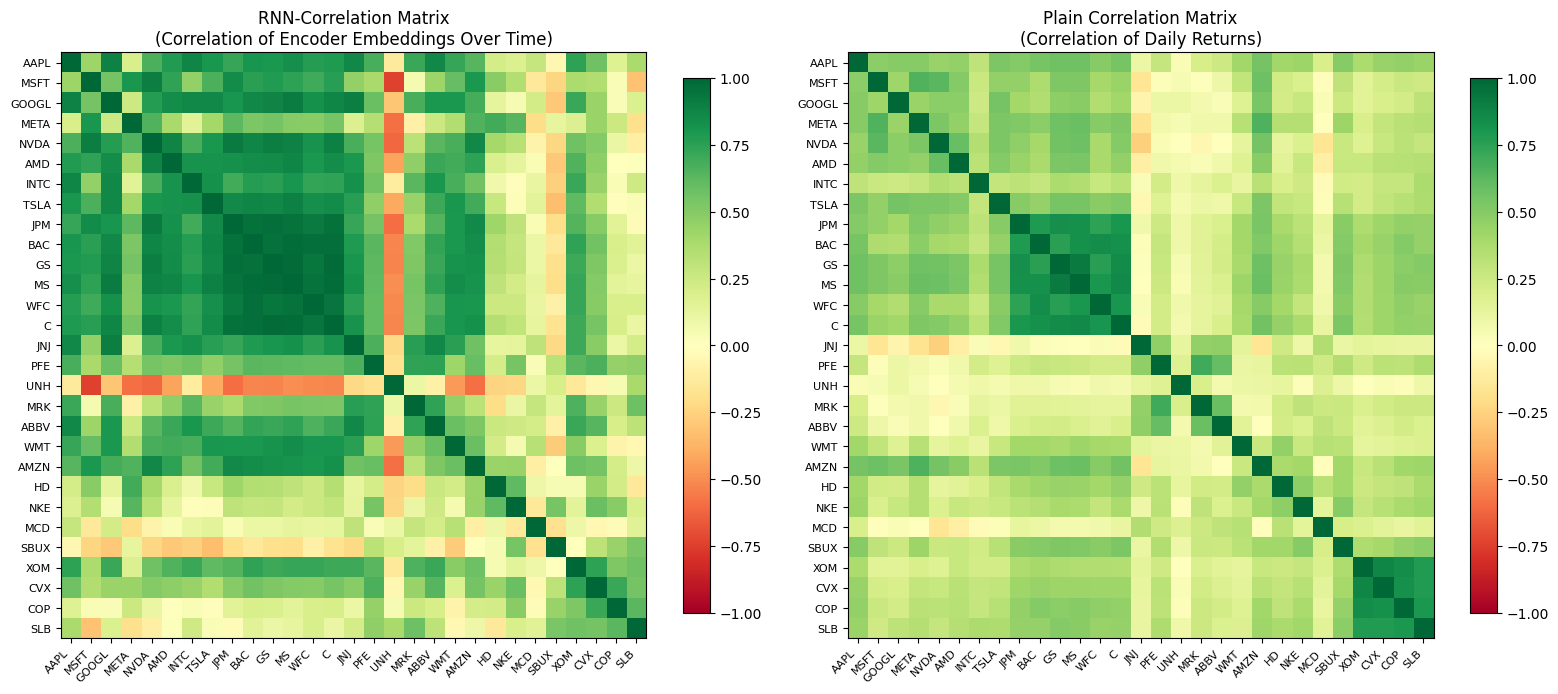


Correlation matrices saved to 'correlation_matrices_comparison.png'


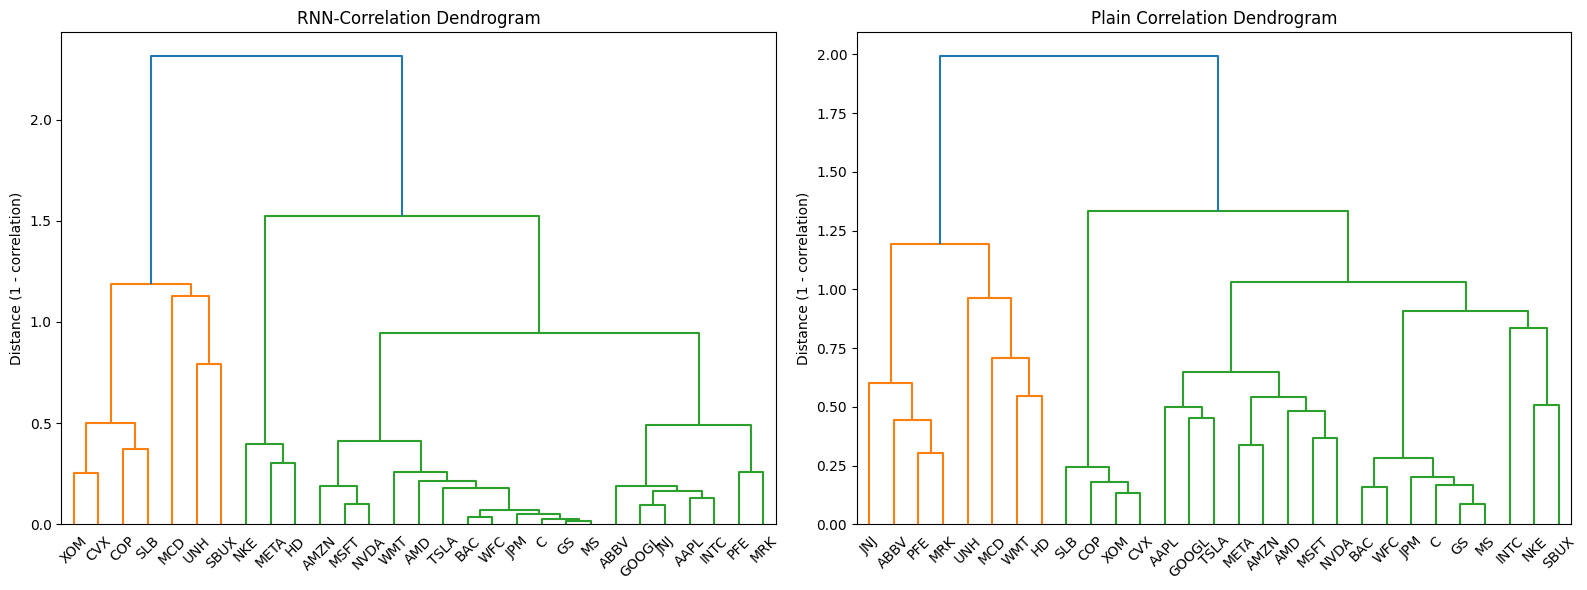

Dendrograms saved to 'dendrograms_comparison.png'


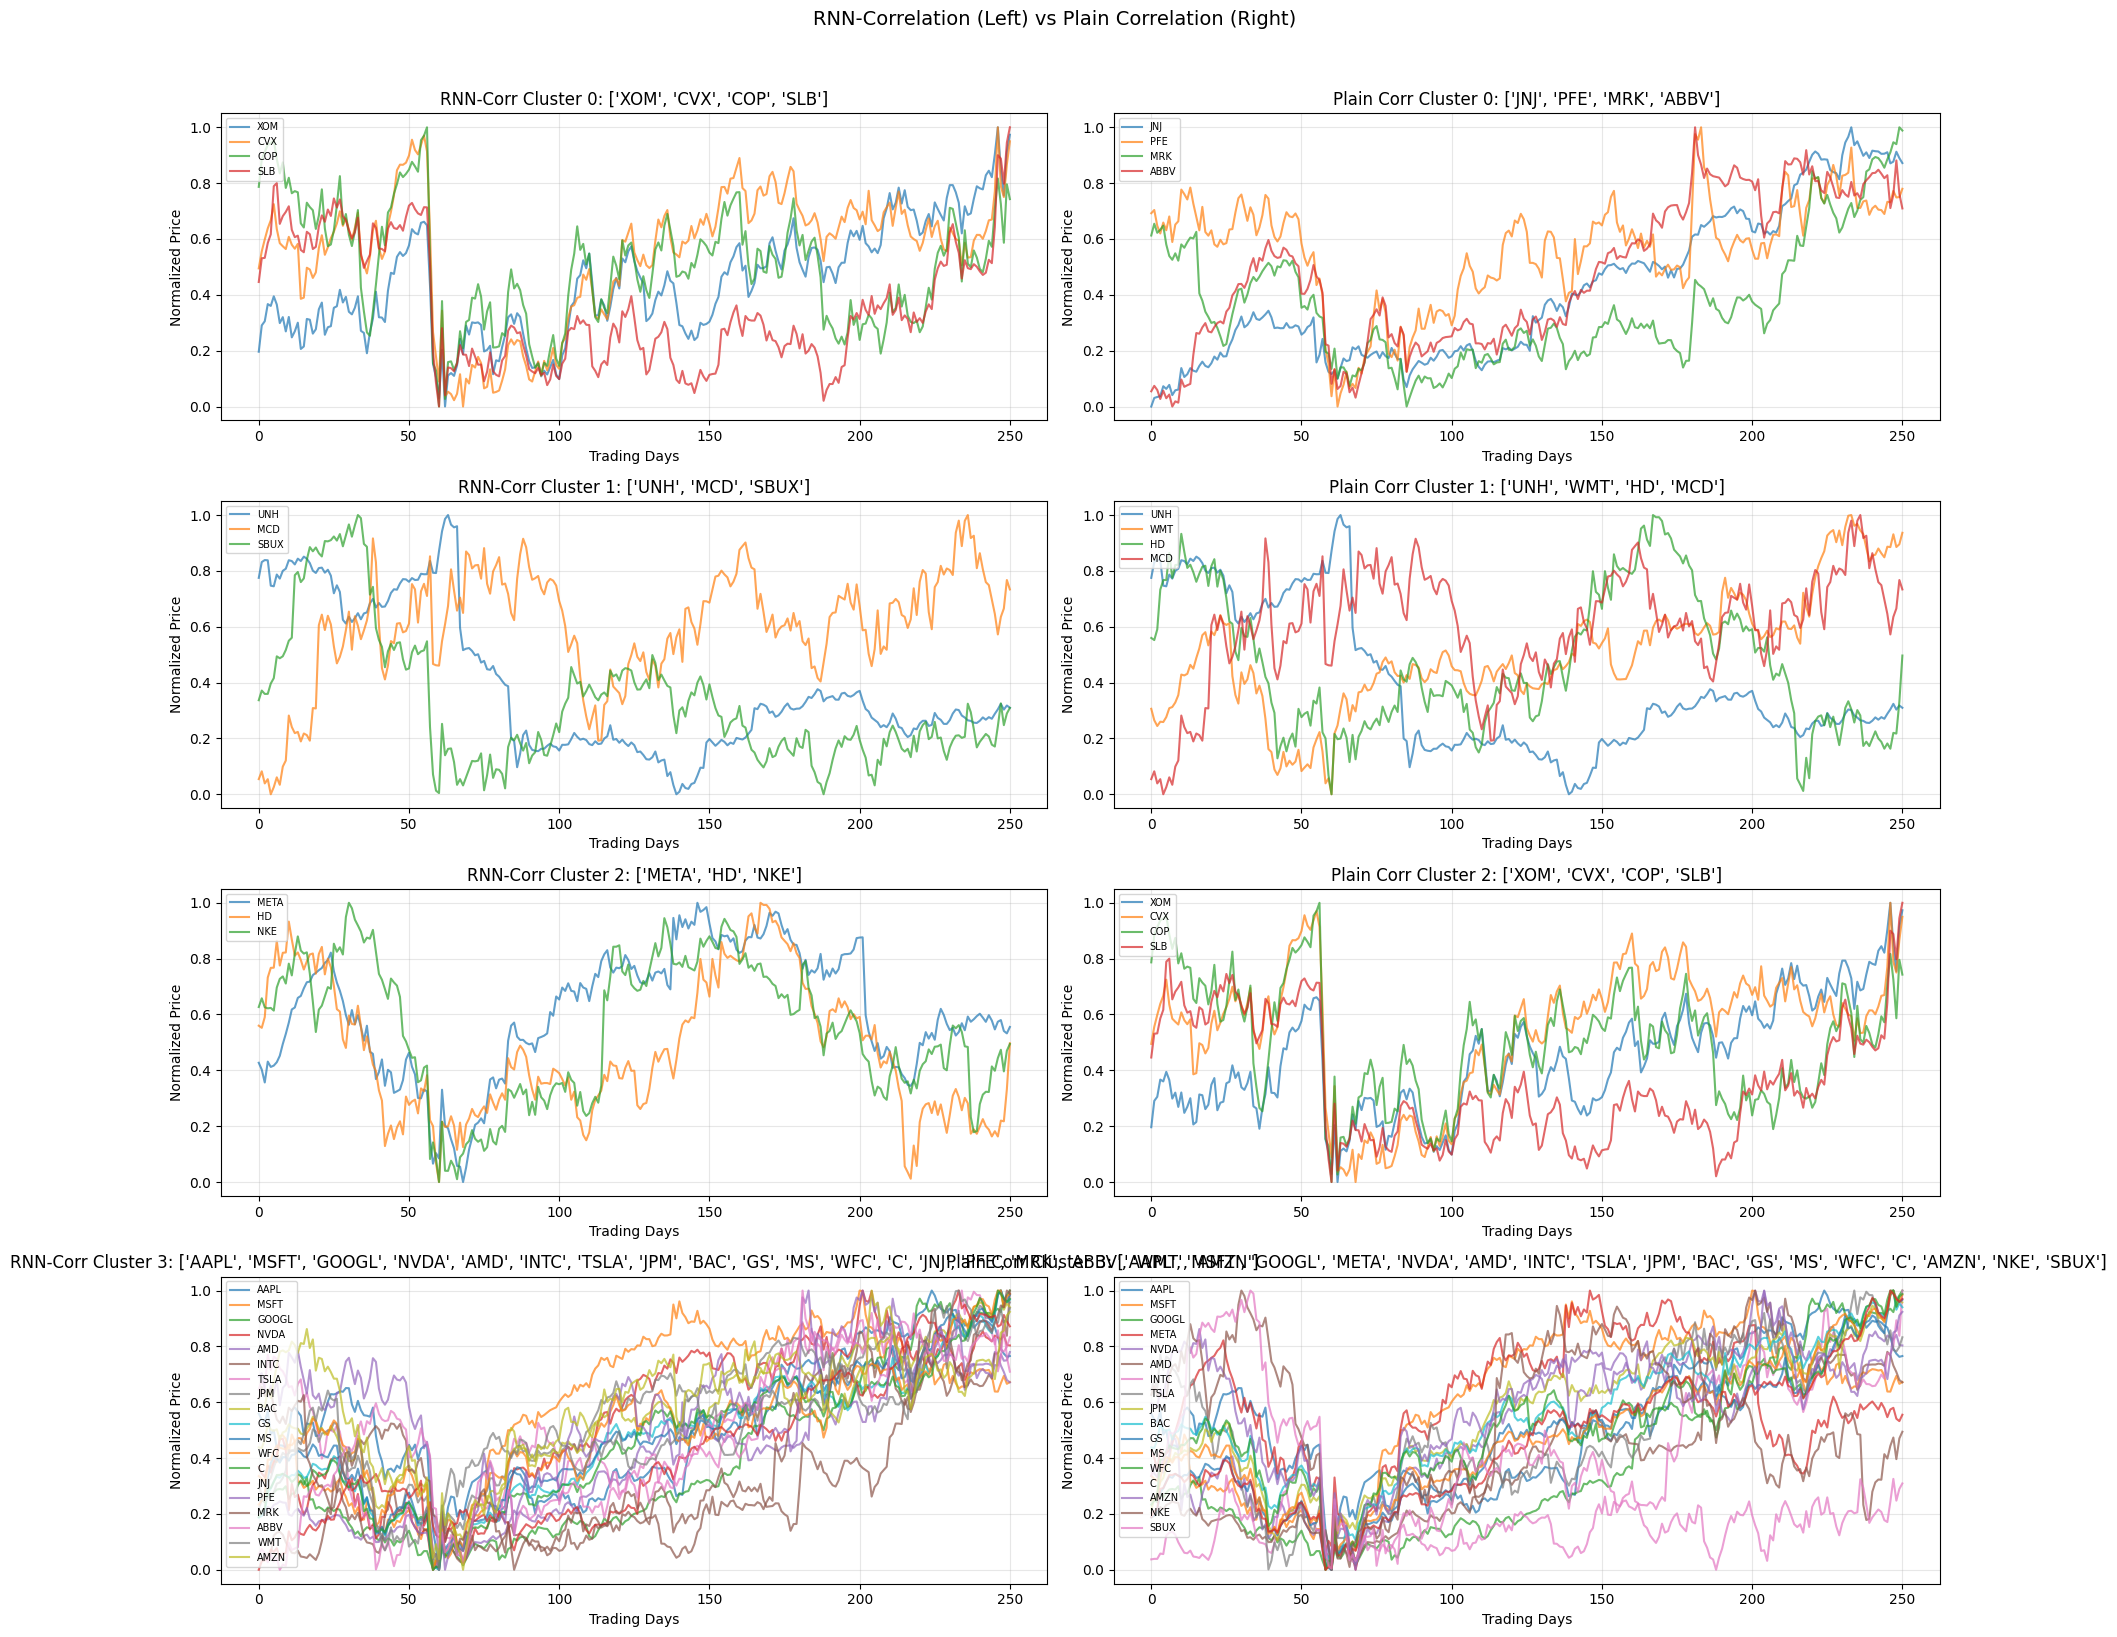


Cluster visualization saved to 'correlation_clusters_comparison.png'

SUMMARY

Method Comparison:
-----------------
• RNN-Correlation:
  - Uses encoder embeddings (learned representations)
  - Captures correlation of "latent pattern dynamics" over time
  - May find deeper structural similarities

• Plain Correlation:
  - Uses raw daily returns
  - Captures stocks that move up/down together on same days
  - Traditional approach, highly interpretable

Adjusted Rand Index: 0.3591
→ Methods produce different groupings.



In [15]:
# =============================================================================
# 8. Comparison
# =============================================================================
print("\n" + "="*70)
print("COMPARISON: RNN-Correlation vs Plain Correlation")
print("="*70)

print("\n{:<8} | {:<18} | {:<18}".format("Ticker", "RNN-Correlation", "Plain Correlation"))
print("-" * 50)
for i, ticker in enumerate(ticker_list):
    rnn_cl = labels_rnn_corr[i]
    plain_cl = labels_plain_corr[i]
    match = "✓" if rnn_cl == plain_cl else ""
    print(f"{ticker:<8} | Cluster {rnn_cl:<10} | Cluster {plain_cl:<10} {match}")

ari_score = adjusted_rand_score(labels_rnn_corr, labels_plain_corr)
print(f"\nAdjusted Rand Index: {ari_score:.4f}")
print("(1.0 = identical, 0.0 = random)")

# =============================================================================
# 9. Visualization: Correlation Matrices Heatmaps
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# RNN Correlation Matrix
im1 = axes[0].imshow(rnn_corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_xticks(range(n_stocks))
axes[0].set_yticks(range(n_stocks))
axes[0].set_xticklabels(ticker_list, rotation=45, ha='right', fontsize=8)
axes[0].set_yticklabels(ticker_list, fontsize=8)
axes[0].set_title('RNN-Correlation Matrix\n(Correlation of Encoder Embeddings Over Time)')
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Plain Correlation Matrix
im2 = axes[1].imshow(plain_corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_xticks(range(n_stocks))
axes[1].set_yticks(range(n_stocks))
axes[1].set_xticklabels(ticker_list, rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels(ticker_list, fontsize=8)
axes[1].set_title('Plain Correlation Matrix\n(Correlation of Daily Returns)')
plt.colorbar(im2, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.savefig('correlation_matrices_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nCorrelation matrices saved to 'correlation_matrices_comparison.png'")

# =============================================================================
# 10. Visualization: Dendrograms
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RNN-Correlation Dendrogram
axes[0].set_title('RNN-Correlation Dendrogram')
dendrogram(linkage_rnn, labels=ticker_list, ax=axes[0], leaf_rotation=45)
axes[0].set_ylabel('Distance (1 - correlation)')

# Plain Correlation Dendrogram
axes[1].set_title('Plain Correlation Dendrogram')
dendrogram(linkage_plain, labels=ticker_list, ax=axes[1], leaf_rotation=45)
axes[1].set_ylabel('Distance (1 - correlation)')

plt.tight_layout()
plt.savefig('dendrograms_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Dendrograms saved to 'dendrograms_comparison.png'")

# =============================================================================
# 11. Visualization: Cluster Price Plots (Side by Side)
# =============================================================================
fig, axes = plt.subplots(n_clusters, 2, figsize=(18, 4 * n_clusters))

for cluster_id in range(n_clusters):
    # RNN-Correlation clusters (left)
    ax_rnn = axes[cluster_id, 0] if n_clusters > 1 else axes[0]
    for ticker in clusters_rnn_corr[cluster_id]:
        prices = stock_data[ticker]['raw_prices'].flatten()
        normalized = (prices - prices.min()) / (prices.max() - prices.min())
        ax_rnn.plot(normalized, label=ticker, alpha=0.7)
    ax_rnn.set_title(f'RNN-Corr Cluster {cluster_id}: {clusters_rnn_corr[cluster_id]}')
    ax_rnn.set_xlabel('Trading Days')
    ax_rnn.set_ylabel('Normalized Price')
    ax_rnn.legend(loc='upper left', fontsize=7)
    ax_rnn.grid(True, alpha=0.3)

    # Plain Correlation clusters (right)
    ax_plain = axes[cluster_id, 1] if n_clusters > 1 else axes[1]
    for ticker in clusters_plain_corr[cluster_id]:
        prices = stock_data[ticker]['raw_prices'].flatten()
        normalized = (prices - prices.min()) / (prices.max() - prices.min())
        ax_plain.plot(normalized, label=ticker, alpha=0.7)
    ax_plain.set_title(f'Plain Corr Cluster {cluster_id}: {clusters_plain_corr[cluster_id]}')
    ax_plain.set_xlabel('Trading Days')
    ax_plain.set_ylabel('Normalized Price')
    ax_plain.legend(loc='upper left', fontsize=7)
    ax_plain.grid(True, alpha=0.3)

plt.suptitle('RNN-Correlation (Left) vs Plain Correlation (Right)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('correlation_clusters_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCluster visualization saved to 'correlation_clusters_comparison.png'")

# =============================================================================
# 12. Summary Statistics
# =============================================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"""
Method Comparison:
-----------------
• RNN-Correlation:
  - Uses encoder embeddings (learned representations)
  - Captures correlation of "latent pattern dynamics" over time
  - May find deeper structural similarities

• Plain Correlation:
  - Uses raw daily returns
  - Captures stocks that move up/down together on same days
  - Traditional approach, highly interpretable

Adjusted Rand Index: {ari_score:.4f}
{"→ Clusters are very similar!" if ari_score > 0.7 else "→ Methods produce different groupings."}
""")


# Port Diversification

In [2]:
# =============================================================================
# 1. Seq2Seq Model (Same as test.py and test2.py)
# =============================================================================
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, x):
        _, h_next = self.rnn(x)
        return h_next

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_prev):
        out, h_next = self.rnn(x, h_prev)
        return self.fc(out), h_next

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len

    def forward(self, x):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        context_vector = self.encoder(x)
        h_prev = context_vector
        decoder_input = torch.zeros(batch_size, 1, output_size).to(x.device)
        outputs = []
        for t in range(self.target_len):
            pred, h_next = self.decoder(decoder_input, h_prev)
            outputs.append(pred)
            decoder_input = pred
            h_prev = h_next
        return torch.cat(outputs, dim=1)

    def encode_only(self, x):
        context = self.encoder(x)
        batch_size = x.size(0)
        return context.transpose(0, 1).reshape(batch_size, -1)

In [20]:
# =============================================================================
# 2. Data Preparation
# =============================================================================
print("="*70)
print("PORTFOLIO DIVERSIFICATION STRATEGY COMPARISON")
print("="*70)

tickers = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'TSLA',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
    # Consumer
    'WMT', 'AMZN', 'HD', 'NKE', 'MCD', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB',
]

period = '1y'
sequence_length = 30
target_len = 5
n_clusters = 4

print(f"\nFetching data for {len(tickers)} stocks...")

stock_data = {}
all_sequences = []
all_targets = []
returns_dict = {}

for ticker in tickers:
    try:
        data = yf.Ticker(ticker).history(period=period)
        if len(data) < sequence_length + target_len:
            print(f"  Skipping {ticker}: Not enough data")
            continue

        close_prices = data['Close'].values.reshape(-1, 1)

        # Calculate daily returns
        returns = np.diff(close_prices.flatten()) / (close_prices.flatten()[:-1] + 1e-8)
        returns_dict[ticker] = returns

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)

        X_list = []
        y_list = []
        for i in range(len(scaled_data) - sequence_length - target_len + 1):
            X_list.append(scaled_data[i:i + sequence_length])
            y_list.append(scaled_data[i + sequence_length:i + sequence_length + target_len])

        if len(X_list) > 0:
            stock_data[ticker] = {
                'scaler': scaler,
                'X': np.array(X_list),
                'y': np.array(y_list),
                'raw_prices': close_prices,
                'returns': returns,
                'dates': data.index
            }
            all_sequences.extend(X_list)
            all_targets.extend(y_list)
            print(f"  {ticker}: loaded")
    except Exception as e:
        print(f"  Error fetching {ticker}: {e}")

X = torch.tensor(np.array(all_sequences), dtype=torch.float32)
y = torch.tensor(np.array(all_targets), dtype=torch.float32)

ticker_list = list(stock_data.keys())
n_stocks = len(ticker_list)
print(f"\nLoaded {n_stocks} stocks, {X.shape[0]} total sequences")

PORTFOLIO DIVERSIFICATION STRATEGY COMPARISON

Fetching data for 29 stocks...
  AAPL: loaded
  MSFT: loaded
  GOOGL: loaded
  META: loaded
  NVDA: loaded
  AMD: loaded
  INTC: loaded
  TSLA: loaded
  JPM: loaded
  BAC: loaded
  GS: loaded
  MS: loaded
  WFC: loaded
  C: loaded
  JNJ: loaded
  PFE: loaded
  UNH: loaded
  MRK: loaded
  ABBV: loaded
  WMT: loaded
  AMZN: loaded
  HD: loaded
  NKE: loaded
  MCD: loaded
  SBUX: loaded
  XOM: loaded
  CVX: loaded
  COP: loaded
  SLB: loaded

Loaded 29 stocks, 6293 total sequences


In [4]:
# =============================================================================
# 3. Train RNN Model
# =============================================================================
print("\n" + "="*70)
print("TRAINING RNN ENCODER")
print("="*70)

input_size = 1
hidden_size = 64
n_layers = 2
output_size = 1

enc = Encoder(input_size, hidden_size, n_layers)
dec = Decoder(output_size, hidden_size, output_size, n_layers)
model = Seq2Seq(enc, dec, target_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 25 == 0:
        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Training complete.")
model.eval()


TRAINING RNN ENCODER
  Epoch [25/100], Loss: 0.058472
  Epoch [50/100], Loss: 0.011086
  Epoch [75/100], Loss: 0.008361
  Epoch [100/100], Loss: 0.007806
Training complete.


Seq2Seq(
  (encoder): Encoder(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [16]:
# =============================================================================
# 4. Extract Features for All Clustering Methods
# =============================================================================
print("\n" + "="*70)
print("EXTRACTING FEATURES FOR CLUSTERING")
print("="*70)

# 4.1 RNN Embeddings (for RNN-KMeans and RNN-Correlation)
rnn_embeddings = {}
rnn_embedding_series = {}

with torch.no_grad():
    for ticker in ticker_list:
        X_stock = torch.tensor(stock_data[ticker]['X'], dtype=torch.float32)
        embeddings = model.encode_only(X_stock).numpy()
        rnn_embedding_series[ticker] = embeddings
        rnn_embeddings[ticker] = embeddings.mean(axis=0)  # Mean for K-Means

# 4.2 Simple Statistical Features (for Plain K-Means)
def extract_simple_features(prices):
    prices = prices.flatten()
    normalized = (prices - prices.min()) / (prices.max() - prices.min() + 1e-8)
    returns = np.diff(prices) / (prices[:-1] + 1e-8)

    features = [
        np.mean(returns), np.std(returns), np.min(returns), np.max(returns),
        (prices[-1] - prices[0]) / (prices[0] + 1e-8),
        np.mean(normalized[:len(normalized)//2]),
        np.mean(normalized[len(normalized)//2:]),
        np.mean(returns[-20:]) if len(returns) >= 20 else np.mean(returns),
        np.mean(returns[:20]) if len(returns) >= 20 else np.mean(returns),
        normalized[0], normalized[len(normalized)//4], normalized[len(normalized)//2],
        normalized[3*len(normalized)//4], normalized[-1],
    ]
    return np.array(features)

simple_features = {t: extract_simple_features(stock_data[t]['raw_prices']) for t in ticker_list}

# 4.3 Correlation Matrices
# RNN-Correlation
min_len = min(emb.shape[0] for emb in rnn_embedding_series.values())
embedding_dim = hidden_size * n_layers
rnn_corr_matrix = np.zeros((n_stocks, n_stocks))

for i, ti in enumerate(ticker_list):
    for j, tj in enumerate(ticker_list):
        if i == j:
            rnn_corr_matrix[i, j] = 1.0
        elif i < j:
            emb_i = rnn_embedding_series[ti][:min_len]
            emb_j = rnn_embedding_series[tj][:min_len]
            correlations = []
            for d in range(embedding_dim):
                corr = np.corrcoef(emb_i[:, d], emb_j[:, d])[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
            avg_corr = np.mean(correlations) if correlations else 0
            rnn_corr_matrix[i, j] = avg_corr
            rnn_corr_matrix[j, i] = avg_corr

# Plain Correlation
min_return_len = min(len(returns_dict[t]) for t in ticker_list)
returns_matrix = np.array([returns_dict[t][:min_return_len] for t in ticker_list])
plain_corr_matrix = np.corrcoef(returns_matrix)

print("Feature extraction complete.")


EXTRACTING FEATURES FOR CLUSTERING
Feature extraction complete.


In [17]:
# =============================================================================
# 4-2. Small statistical check
# =============================================================================
print("\n" + "="*70)
print("ADF TEST - STATIONARITY AND COINTEGRATION ANALYSIS")
print("="*70)

def adf_test(series, name=""):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    Returns: (statistic, p-value, is_stationary)
    """
    try:
        result = adfuller(series, autolag='AIC')
        adf_stat = result[0]
        p_value = result[1]
        # Stationary if p-value < 0.05 (reject null hypothesis of unit root)
        is_stationary = p_value < 0.05
        return adf_stat, p_value, is_stationary
    except:
        return None, None, None

# 4.5.1 Test Raw Price Stationarity
print("\n--- Raw Price Stationarity Test ---")
price_stationarity = {}
for ticker in ticker_list:
    prices = stock_data[ticker]['raw_prices'].flatten()
    adf_stat, p_value, is_stationary = adf_test(prices, ticker)
    price_stationarity[ticker] = {
        'adf_stat': adf_stat,
        'p_value': p_value,
        'is_stationary': is_stationary
    }

stationary_count = sum(1 for v in price_stationarity.values() if v['is_stationary'])
print(f"  Raw Prices: {stationary_count}/{len(ticker_list)} stocks are stationary (p < 0.05)")
print("  (Non-stationary prices are expected - prices have unit root)")

# 4.5.2 Test Returns Stationarity (should be stationary)
print("\n--- Returns Stationarity Test ---")
returns_stationarity = {}
for ticker in ticker_list:
    returns = returns_dict[ticker]
    adf_stat, p_value, is_stationary = adf_test(returns, ticker)
    returns_stationarity[ticker] = {
        'adf_stat': adf_stat,
        'p_value': p_value,
        'is_stationary': is_stationary
    }

stationary_count = sum(1 for v in returns_stationarity.values() if v['is_stationary'])
print(f"  Returns: {stationary_count}/{len(ticker_list)} stocks are stationary (p < 0.05)")
print("  (Returns should be stationary - good for modeling)")

# 4.5.3 Test RNN Embedding Stationarity
print("\n--- RNN Embedding Stationarity Test ---")
embedding_stationarity = {}

# Test first few dimensions of embeddings for each stock
n_dims_to_test = min(5, embedding_dim)  # Test first 5 dimensions

for ticker in ticker_list:
    emb_series = rnn_embedding_series[ticker]
    dim_results = []

    for d in range(n_dims_to_test):
        adf_stat, p_value, is_stationary = adf_test(emb_series[:, d])
        if p_value is not None:
            dim_results.append(is_stationary)

    # Check if majority of dimensions are stationary
    stationary_ratio = sum(dim_results) / len(dim_results) if dim_results else 0
    embedding_stationarity[ticker] = {
        'stationary_ratio': stationary_ratio,
        'is_mostly_stationary': stationary_ratio > 0.5
    }

mostly_stationary = sum(1 for v in embedding_stationarity.values() if v['is_mostly_stationary'])
print(f"  RNN Embeddings: {mostly_stationary}/{len(ticker_list)} stocks have mostly stationary embeddings")
print(f"  (Testing first {n_dims_to_test} embedding dimensions)")

# 4.5.4 Cointegration Test Between Stock Pairs
print("\n--- Cointegration Test Between Stock Pairs ---")
print("  Testing if stock pairs share long-term equilibrium relationships...")

# Test cointegration for a sample of stock pairs (testing all pairs is expensive)
sample_pairs = []
for i, ti in enumerate(ticker_list[:10]):  # Test first 10 stocks
    for j, tj in enumerate(ticker_list[:10]):
        if i < j:
            sample_pairs.append((ti, tj))

cointegration_results = {}
cointegrated_pairs = []

for ti, tj in sample_pairs:
    prices_i = stock_data[ti]['raw_prices'].flatten()
    prices_j = stock_data[tj]['raw_prices'].flatten()

    # Align lengths
    min_len = min(len(prices_i), len(prices_j))
    prices_i = prices_i[:min_len]
    prices_j = prices_j[:min_len]

    try:
        # Engle-Granger cointegration test
        score, p_value, _ = coint(prices_i, prices_j)
        is_cointegrated = p_value < 0.05
        cointegration_results[(ti, tj)] = {
            'score': score,
            'p_value': p_value,
            'is_cointegrated': is_cointegrated
        }
        if is_cointegrated:
            cointegrated_pairs.append((ti, tj, p_value))
    except:
        pass

print(f"  Tested {len(sample_pairs)} stock pairs")
print(f"  Found {len(cointegrated_pairs)} cointegrated pairs (p < 0.05)")

if cointegrated_pairs:
    print("\n  Top Cointegrated Pairs:")
    sorted_pairs = sorted(cointegrated_pairs, key=lambda x: x[2])[:10]
    for ti, tj, pval in sorted_pairs:
        print(f"    {ti} <-> {tj}: p-value = {pval:.4f}")

# 4.5.5 Test Cointegration on RNN Embeddings
print("\n--- RNN Embedding Cointegration Test ---")
print("  Testing if RNN embedding series are cointegrated between stocks...")

rnn_cointegrated_pairs = []

for ti, tj in sample_pairs[:20]:  # Test fewer pairs for speed
    emb_i = rnn_embedding_series[ti][:min_len, 0]  # Use first dimension
    emb_j = rnn_embedding_series[tj][:min_len, 0]

    try:
        score, p_value, _ = coint(emb_i, emb_j)
        if p_value < 0.05:
            rnn_cointegrated_pairs.append((ti, tj, p_value))
    except:
        pass

print(f"  Found {len(rnn_cointegrated_pairs)} cointegrated embedding pairs")

if rnn_cointegrated_pairs:
    print("\n  Cointegrated Embedding Pairs:")
    for ti, tj, pval in sorted(rnn_cointegrated_pairs, key=lambda x: x[2])[:5]:
        print(f"    {ti} <-> {tj}: p-value = {pval:.4f}")

# Summary
print("\n--- ADF Test Summary ---")
print(f"""
  Stationarity Analysis:
  ├─ Raw Prices: Mostly non-stationary (expected - unit root)
  ├─ Returns: Mostly stationary (good for modeling)
  └─ RNN Embeddings: {mostly_stationary}/{len(ticker_list)} stocks have stationary embeddings

  Cointegration Analysis:
  ├─ Raw Price Pairs: {len(cointegrated_pairs)}/{len(sample_pairs)} pairs cointegrated
  └─ RNN Embedding Pairs: {len(rnn_cointegrated_pairs)} pairs cointegrated

  Implications for Clustering:
  • Cointegrated pairs may cluster together (shared long-term dynamics)
  • Stationary RNN embeddings suggest stable learned representations
  • Consider using differenced/stationary features for better clustering
""")


ADF TEST - STATIONARITY AND COINTEGRATION ANALYSIS

--- Raw Price Stationarity Test ---
  Raw Prices: 2/29 stocks are stationary (p < 0.05)
  (Non-stationary prices are expected - prices have unit root)

--- Returns Stationarity Test ---
  Returns: 29/29 stocks are stationary (p < 0.05)
  (Returns should be stationary - good for modeling)

--- RNN Embedding Stationarity Test ---
  RNN Embeddings: 2/29 stocks have mostly stationary embeddings
  (Testing first 5 embedding dimensions)

--- Cointegration Test Between Stock Pairs ---
  Testing if stock pairs share long-term equilibrium relationships...
  Tested 45 stock pairs
  Found 2 cointegrated pairs (p < 0.05)

  Top Cointegrated Pairs:
    NVDA <-> JPM: p-value = 0.0124
    JPM <-> BAC: p-value = 0.0426

--- RNN Embedding Cointegration Test ---
  Testing if RNN embedding series are cointegrated between stocks...
  Found 1 cointegrated embedding pairs

  Cointegrated Embedding Pairs:
    AAPL <-> GOOGL: p-value = 0.0114

--- ADF Test 

In [18]:
# =============================================================================
# 5. Perform All 4 Clustering Methods
# =============================================================================
print("\n" + "="*70)
print("PERFORMING 4 CLUSTERING METHODS")
print("="*70)

clustering_results = {}

# 5.1 RNN-KMeans
rnn_embedding_matrix = np.array([rnn_embeddings[t] for t in ticker_list])
kmeans_rnn = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_rnn_kmeans = kmeans_rnn.fit_predict(rnn_embedding_matrix)
clustering_results['RNN-KMeans'] = {t: labels_rnn_kmeans[i] for i, t in enumerate(ticker_list)}
print("  ✓ RNN-KMeans clustering complete")

# 5.2 Plain K-Means
simple_feature_matrix = np.array([simple_features[t] for t in ticker_list])
scaler_features = StandardScaler()
simple_feature_matrix_scaled = scaler_features.fit_transform(simple_feature_matrix)
kmeans_plain = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_plain_kmeans = kmeans_plain.fit_predict(simple_feature_matrix_scaled)
clustering_results['Plain-KMeans'] = {t: labels_plain_kmeans[i] for i, t in enumerate(ticker_list)}
print("  ✓ Plain K-Means clustering complete")

# 5.3 RNN-Correlation (Hierarchical)
def cluster_from_corr_matrix(corr_matrix, n_clusters):
    distance_matrix = 1 - corr_matrix
    np.fill_diagonal(distance_matrix, 0)
    distance_matrix = np.clip(distance_matrix, 0, 2)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    condensed_dist = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_dist, method='ward')
    labels = fcluster(Z, n_clusters, criterion='maxclust') - 1
    return labels

labels_rnn_corr = cluster_from_corr_matrix(rnn_corr_matrix, n_clusters)
clustering_results['RNN-Correlation'] = {t: labels_rnn_corr[i] for i, t in enumerate(ticker_list)}
print("  ✓ RNN-Correlation clustering complete")

# 5.4 Plain Correlation (Hierarchical)
labels_plain_corr = cluster_from_corr_matrix(plain_corr_matrix, n_clusters)
clustering_results['Plain-Correlation'] = {t: labels_plain_corr[i] for i, t in enumerate(ticker_list)}
print("  ✓ Plain-Correlation clustering complete")

# Print clusters for each method
print("\nClustering Results:")
for method, cluster_dict in clustering_results.items():
    clusters = {i: [] for i in range(n_clusters)}
    for ticker, label in cluster_dict.items():
        clusters[label].append(ticker)
    print(f"\n{method}:")
    for cluster_id, stocks in clusters.items():
        print(f"  Cluster {cluster_id}: {stocks}")


PERFORMING 4 CLUSTERING METHODS
  ✓ RNN-KMeans clustering complete
  ✓ Plain K-Means clustering complete
  ✓ RNN-Correlation clustering complete
  ✓ Plain-Correlation clustering complete

Clustering Results:

RNN-KMeans:
  Cluster 0: ['AMD', 'TSLA', 'GS', 'MS', 'C', 'JNJ', 'HD', 'XOM', 'COP']
  Cluster 1: ['GOOGL', 'INTC', 'UNH', 'MRK', 'SBUX', 'SLB']
  Cluster 2: ['MSFT', 'META', 'MCD']
  Cluster 3: ['AAPL', 'NVDA', 'JPM', 'BAC', 'WFC', 'PFE', 'ABBV', 'WMT', 'AMZN', 'NKE', 'CVX']

Plain-KMeans:
  Cluster 0: ['GOOGL', 'JPM', 'GS', 'MS', 'WFC', 'C', 'JNJ', 'MRK', 'ABBV', 'WMT', 'XOM']
  Cluster 1: ['UNH', 'SBUX', 'SLB']
  Cluster 2: ['NVDA', 'AMD', 'INTC', 'TSLA']
  Cluster 3: ['AAPL', 'MSFT', 'META', 'BAC', 'PFE', 'AMZN', 'HD', 'NKE', 'MCD', 'CVX', 'COP']

RNN-Correlation:
  Cluster 0: ['XOM', 'CVX', 'COP', 'SLB']
  Cluster 1: ['UNH', 'MCD', 'SBUX']
  Cluster 2: ['META', 'HD', 'NKE']
  Cluster 3: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMD', 'INTC', 'TSLA', 'JPM', 'BAC', 'GS', 'MS', 'WFC',

In [21]:
# =============================================================================
# 6. Portfolio Construction Strategy
# =============================================================================
print("\n" + "="*70)
print("PORTFOLIO CONSTRUCTION STRATEGY")
print("="*70)
print("\nStrategy: Select ONE stock from EACH cluster for diversification")
print("Selection criterion: Stock with highest Sharpe ratio in each cluster")

def calculate_sharpe(returns, risk_free_rate=0.02):
    """Calculate annualized Sharpe ratio."""
    excess_returns = returns - risk_free_rate / 252
    if np.std(returns) == 0:
        return 0
    return np.mean(excess_returns) / np.std(returns) * np.sqrt(252)

# For each clustering method, select best stock from each cluster
portfolios = {}

for method, cluster_dict in clustering_results.items():
    # Group stocks by cluster
    clusters = {i: [] for i in range(n_clusters)}
    for ticker, label in cluster_dict.items():
        clusters[label].append(ticker)

    # Select best stock (highest Sharpe) from each cluster
    selected_stocks = []
    for cluster_id, stocks in clusters.items():
        if stocks:
            best_stock = max(stocks, key=lambda t: calculate_sharpe(stock_data[t]['returns']))
            selected_stocks.append(best_stock)

    portfolios[method] = selected_stocks
    print(f"\n{method} Portfolio: {selected_stocks}")

# Also create a baseline: Equal-weight all stocks
portfolios['All-Stocks (Baseline)'] = ticker_list


PORTFOLIO CONSTRUCTION STRATEGY

Strategy: Select ONE stock from EACH cluster for diversification
Selection criterion: Stock with highest Sharpe ratio in each cluster

RNN-KMeans Portfolio: ['JNJ', 'GOOGL', 'MSFT', 'JPM']

Plain-KMeans Portfolio: ['JNJ', 'SLB', 'INTC', 'BAC']

RNN-Correlation Portfolio: ['XOM', 'MCD', 'META', 'JNJ']

Plain-Correlation Portfolio: ['JNJ', 'WMT', 'XOM', 'C']


In [22]:
# =============================================================================
# 7. Portfolio Performance Metrics
# =============================================================================
print("\n" + "="*70)
print("PORTFOLIO PERFORMANCE ANALYSIS")
print("="*70)

def calculate_portfolio_metrics(selected_tickers, all_returns_dict, all_dates=None):
    """Calculate portfolio performance metrics."""
    # Align returns to same length
    min_len = min(len(all_returns_dict[t]) for t in selected_tickers)
    returns_matrix = np.array([all_returns_dict[t][:min_len] for t in selected_tickers])

    # Equal-weighted portfolio returns
    portfolio_returns = returns_matrix.mean(axis=0)

    # Metrics
    total_return = (1 + portfolio_returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(portfolio_returns)) - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe = calculate_sharpe(portfolio_returns)

    # Max Drawdown
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Portfolio Correlation (average pairwise correlation)
    if len(selected_tickers) > 1:
        corr_matrix = np.corrcoef(returns_matrix)
        # Get upper triangle (excluding diagonal)
        upper_triangle = corr_matrix[np.triu_indices(len(selected_tickers), k=1)]
        avg_correlation = upper_triangle.mean()
    else:
        avg_correlation = 1.0

    # Diversification Ratio = weighted avg volatility / portfolio volatility
    individual_vols = [all_returns_dict[t][:min_len].std() * np.sqrt(252) for t in selected_tickers]
    avg_individual_vol = np.mean(individual_vols)
    diversification_ratio = avg_individual_vol / volatility if volatility > 0 else 1

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'Avg Correlation': avg_correlation,
        'Diversification Ratio': diversification_ratio,
        'Num Stocks': len(selected_tickers),
        'Portfolio Returns': portfolio_returns,
        'Cumulative Returns': cumulative
    }

# Calculate metrics for all portfolios
results = {}
for method, selected_stocks in portfolios.items():
    results[method] = calculate_portfolio_metrics(selected_stocks, returns_dict)


PORTFOLIO PERFORMANCE ANALYSIS



------------------------------------------------------------------------------------------
Method               | Return     | Vol        | Sharpe     | MaxDD      | AvgCorr    | DivRatio  
------------------------------------------------------------------------------------------
RNN-KMeans           |    45.58% |    16.44% |    2.246 |   -16.12% |    0.188 |    1.533
Plain-KMeans         |    60.69% |    25.91% |    1.884 |   -21.58% |    0.209 |    1.440
RNN-Correlation      |    23.85% |    14.52% |    1.409 |   -11.17% |    0.117 |    1.715
Plain-Correlation    |    43.72% |    16.00% |    2.224 |   -16.32% |    0.185 |    1.563
All-Stocks (Baseline) |    30.73% |    20.03% |    1.338 |   -20.52% |    0.316 |    1.700
------------------------------------------------------------------------------------------

RANKINGS BY METRIC

Sharpe Ratio (↑):
  1. RNN-KMeans
  2. Plain-Correlation
  3. Plain-KMeans
  4. RNN-Correlation

Volatility (↓):
  1. RNN-Correlation
  2. Plain-Correlatio

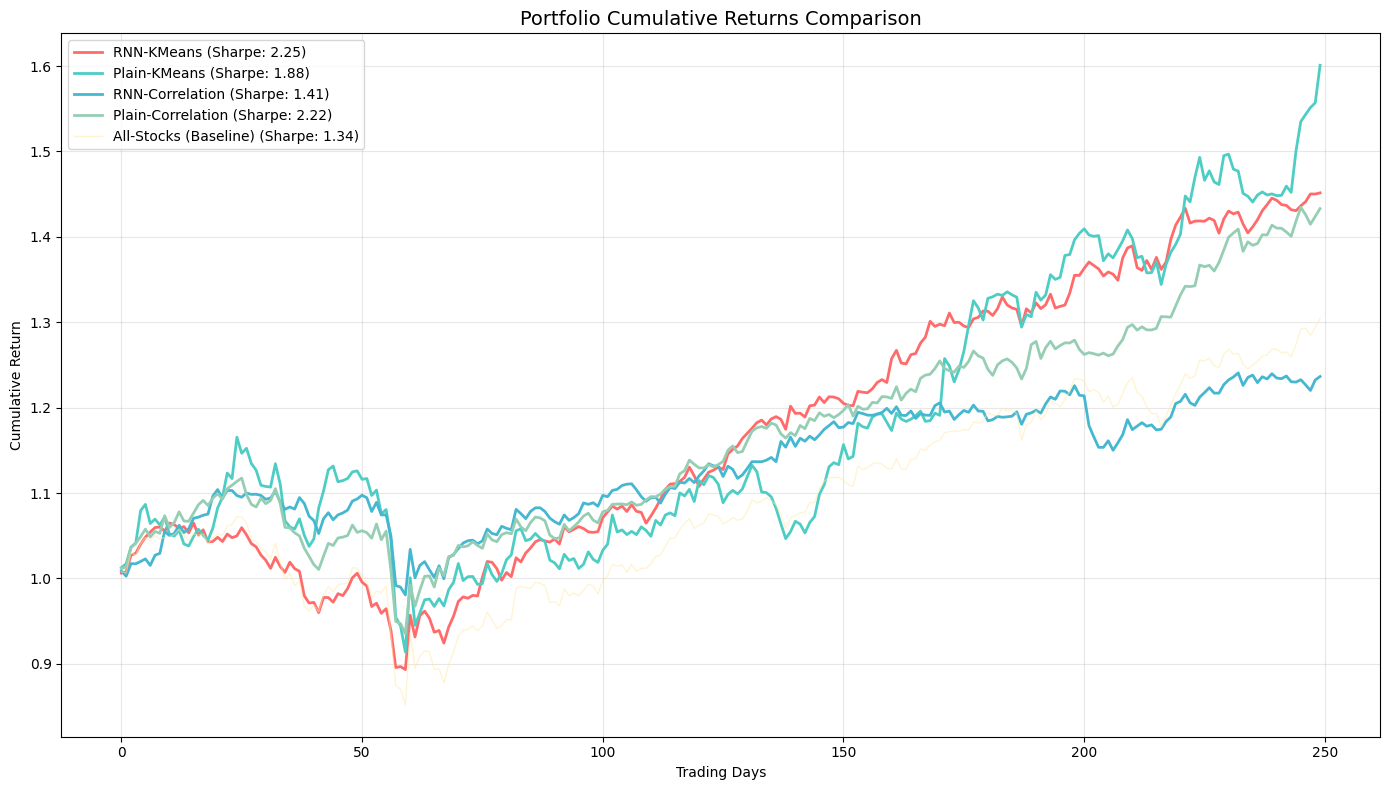


Cumulative returns chart saved to 'portfolio_cumulative_returns.png'


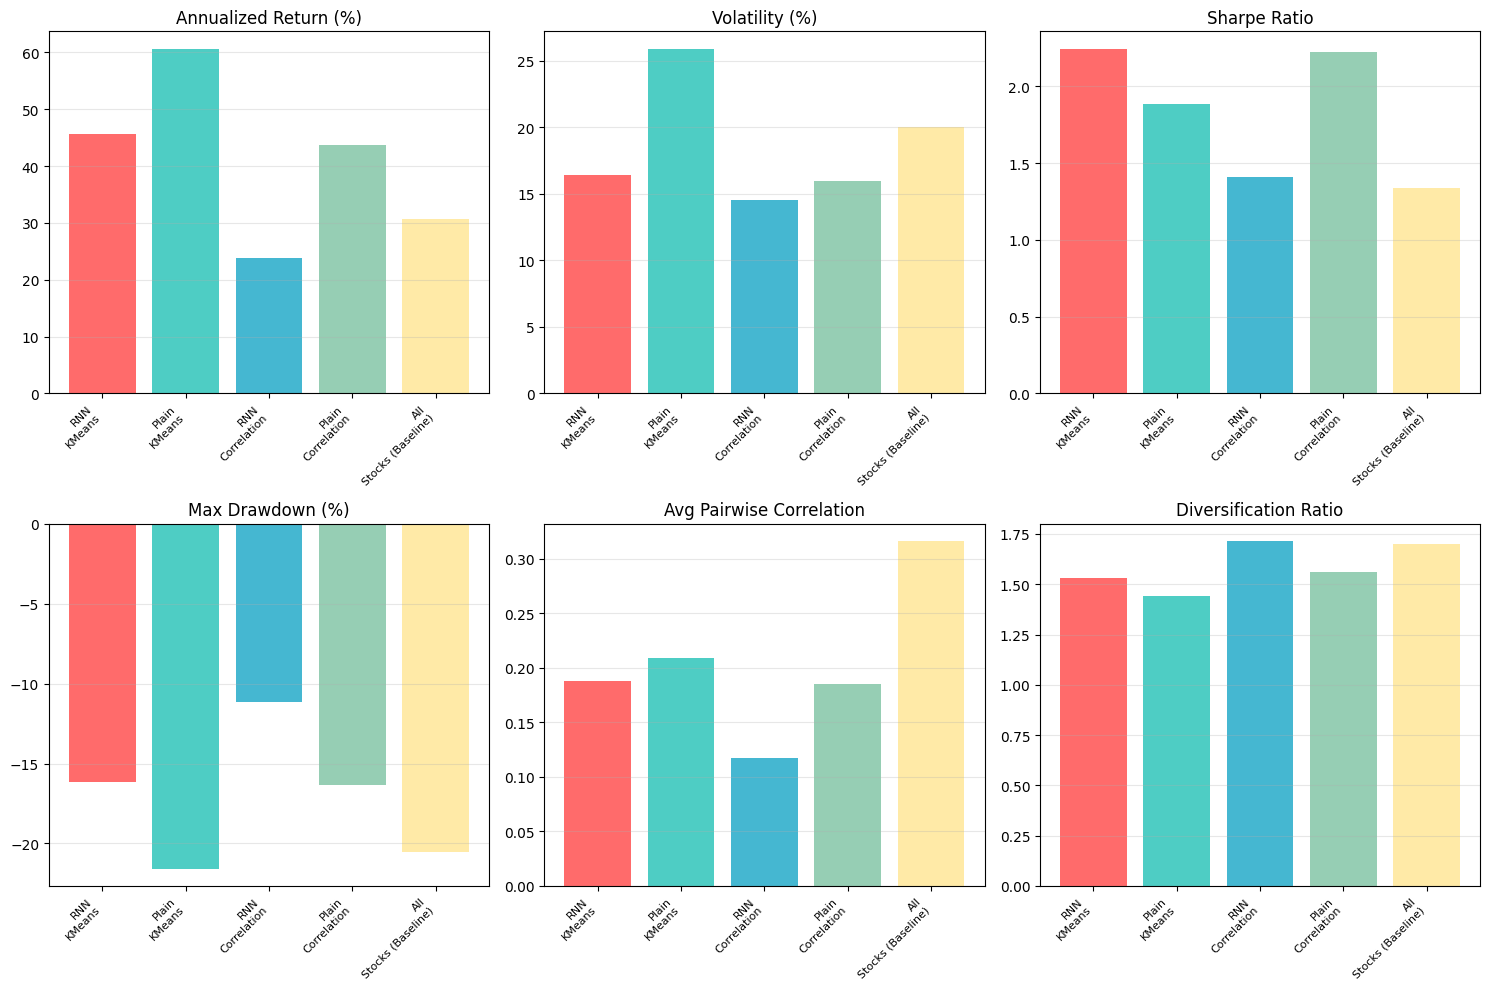

Metrics comparison chart saved to 'portfolio_metrics_comparison.png'

SUMMARY

Portfolio Diversification Strategy Results:
-------------------------------------------
• Best Sharpe Ratio: RNN-KMeans
  → Sharpe: 2.246

• Best Diversification Ratio: RNN-Correlation
  → Div Ratio: 1.715

• Lowest Avg Correlation: RNN-Correlation
  → Avg Corr: 0.117

Key Insights:
-------------
• Higher Diversification Ratio = more effective diversification
• Lower Avg Correlation = less overlap between stock movements
• Higher Sharpe Ratio = better risk-adjusted returns

Comparison vs Baseline (All-Stocks):
• The clustering-based portfolios use only 4 stocks vs 29 stocks
• Compare if diversification is as effective with fewer, strategically selected stocks


Final Verdict:
--------------------------------------------------
RNN-KMeans:
  Sharpe vs Baseline: +0.908
  Div Ratio vs Baseline: -0.167
Plain-KMeans:
  Sharpe vs Baseline: +0.546
  Div Ratio vs Baseline: -0.260
RNN-Correlation:
  Sharpe vs Baseline

In [23]:
# =============================================================================
# 8. Results Comparison Table
# =============================================================================
print("\n" + "-"*90)
print(f"{'Method':<20} | {'Return':<10} | {'Vol':<10} | {'Sharpe':<10} | {'MaxDD':<10} | {'AvgCorr':<10} | {'DivRatio':<10}")
print("-"*90)

for method, metrics in results.items():
    print(f"{method:<20} | {metrics['Annualized Return']*100:>8.2f}% | "
          f"{metrics['Volatility']*100:>8.2f}% | {metrics['Sharpe Ratio']:>8.3f} | "
          f"{metrics['Max Drawdown']*100:>8.2f}% | {metrics['Avg Correlation']:>8.3f} | "
          f"{metrics['Diversification Ratio']:>8.3f}")
print("-"*90)

# =============================================================================
# 9. Rankings
# =============================================================================
print("\n" + "="*70)
print("RANKINGS BY METRIC")
print("="*70)

# Exclude baseline for fair comparison
method_names = [m for m in results.keys() if m != 'All-Stocks (Baseline)']

rankings = {
    'Sharpe Ratio (↑)': sorted(method_names, key=lambda m: results[m]['Sharpe Ratio'], reverse=True),
    'Volatility (↓)': sorted(method_names, key=lambda m: results[m]['Volatility']),
    'Max Drawdown (↓)': sorted(method_names, key=lambda m: results[m]['Max Drawdown'], reverse=True),
    'Avg Correlation (↓)': sorted(method_names, key=lambda m: results[m]['Avg Correlation']),
    'Diversification Ratio (↑)': sorted(method_names, key=lambda m: results[m]['Diversification Ratio'], reverse=True),
}

for metric, ranking in rankings.items():
    print(f"\n{metric}:")
    for i, method in enumerate(ranking, 1):
        print(f"  {i}. {method}")

# =============================================================================
# 10. Visualization: Cumulative Returns
# =============================================================================
plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
for i, (method, metrics) in enumerate(results.items()):
    cumulative = metrics['Cumulative Returns']
    label = f"{method} (Sharpe: {metrics['Sharpe Ratio']:.2f})"
    plt.plot(cumulative, label=label, linewidth=2 if 'Baseline' not in method else 1,
             alpha=0.5 if 'Baseline' in method else 1, color=colors[i % len(colors)])

plt.title('Portfolio Cumulative Returns Comparison', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('portfolio_cumulative_returns.png', dpi=150)
plt.show()
print("\nCumulative returns chart saved to 'portfolio_cumulative_returns.png'")

# =============================================================================
# 11. Visualization: Metrics Comparison Bar Chart
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = [
    ('Annualized Return', 'Annualized Return (%)', lambda x: x * 100),
    ('Volatility', 'Volatility (%)', lambda x: x * 100),
    ('Sharpe Ratio', 'Sharpe Ratio', lambda x: x),
    ('Max Drawdown', 'Max Drawdown (%)', lambda x: x * 100),
    ('Avg Correlation', 'Avg Pairwise Correlation', lambda x: x),
    ('Diversification Ratio', 'Diversification Ratio', lambda x: x),
]

method_labels = list(results.keys())
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for idx, (metric_key, title, transform) in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = [transform(results[m][metric_key]) for m in method_labels]
    bars = ax.bar(range(len(method_labels)), values, color=colors_bar)
    ax.set_xticks(range(len(method_labels)))
    ax.set_xticklabels([m.replace('-', '\n') for m in method_labels], fontsize=8, rotation=45, ha='right')
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('portfolio_metrics_comparison.png', dpi=150)
plt.show()
print("Metrics comparison chart saved to 'portfolio_metrics_comparison.png'")

# =============================================================================
# 12. Summary
# =============================================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

# Find overall best method (by Sharpe)
best_sharpe_method = max(method_names, key=lambda m: results[m]['Sharpe Ratio'])
best_diversification_method = max(method_names, key=lambda m: results[m]['Diversification Ratio'])
lowest_correlation_method = min(method_names, key=lambda m: results[m]['Avg Correlation'])

print(f"""
Portfolio Diversification Strategy Results:
-------------------------------------------
• Best Sharpe Ratio: {best_sharpe_method}
  → Sharpe: {results[best_sharpe_method]['Sharpe Ratio']:.3f}

• Best Diversification Ratio: {best_diversification_method}
  → Div Ratio: {results[best_diversification_method]['Diversification Ratio']:.3f}

• Lowest Avg Correlation: {lowest_correlation_method}
  → Avg Corr: {results[lowest_correlation_method]['Avg Correlation']:.3f}

Key Insights:
-------------
• Higher Diversification Ratio = more effective diversification
• Lower Avg Correlation = less overlap between stock movements
• Higher Sharpe Ratio = better risk-adjusted returns

Comparison vs Baseline (All-Stocks):
• The clustering-based portfolios use only {n_clusters} stocks vs {len(ticker_list)} stocks
• Compare if diversification is as effective with fewer, strategically selected stocks
""")

# Final comparison table
print("\nFinal Verdict:")
print("-"*50)
baseline = results['All-Stocks (Baseline)']
for method in method_names:
    m = results[method]
    sharpe_diff = m['Sharpe Ratio'] - baseline['Sharpe Ratio']
    div_diff = m['Diversification Ratio'] - baseline['Diversification Ratio']
    print(f"{method}:")
    print(f"  Sharpe vs Baseline: {'+' if sharpe_diff >= 0 else ''}{sharpe_diff:.3f}")
    print(f"  Div Ratio vs Baseline: {'+' if div_diff >= 0 else ''}{div_diff:.3f}")


# Long-Short

In [ ]:
# =============================================================================
# 1. Seq2Seq Model (Same as other files)
# =============================================================================
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, x):
        _, h_next = self.rnn(x)
        return h_next

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_prev):
        out, h_next = self.rnn(x, h_prev)
        return self.fc(out), h_next

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len

    def forward(self, x):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        context_vector = self.encoder(x)
        h_prev = context_vector
        decoder_input = torch.zeros(batch_size, 1, output_size).to(x.device)
        outputs = []
        for t in range(self.target_len):
            pred, h_next = self.decoder(decoder_input, h_prev)
            outputs.append(pred)
            decoder_input = pred
            h_prev = h_next
        return torch.cat(outputs, dim=1)

    def encode_only(self, x):
        context = self.encoder(x)
        batch_size = x.size(0)
        return context.transpose(0, 1).reshape(batch_size, -1)


In [ ]:
# =============================================================================
# 2. Data Preparation
# =============================================================================
print("="*70)
print("LONG-SHORT STRATEGY COMPARISON")
print("="*70)

tickers = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'TSLA',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
    # Consumer
    'WMT', 'AMZN', 'HD', 'NKE', 'MCD', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB',
]

period = '1y'
sequence_length = 30
target_len = 5
n_clusters = 4

print(f"\nFetching data for {len(tickers)} stocks...")

stock_data = {}
all_sequences = []
all_targets = []
returns_dict = {}

for ticker in tickers:
    try:
        data = yf.Ticker(ticker).history(period=period)
        if len(data) < sequence_length + target_len:
            print(f"  Skipping {ticker}: Not enough data")
            continue

        close_prices = data['Close'].values.reshape(-1, 1)
        returns = np.diff(close_prices.flatten()) / (close_prices.flatten()[:-1] + 1e-8)
        returns_dict[ticker] = returns

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(close_prices)

        X_list = []
        y_list = []
        for i in range(len(scaled_data) - sequence_length - target_len + 1):
            X_list.append(scaled_data[i:i + sequence_length])
            y_list.append(scaled_data[i + sequence_length:i + sequence_length + target_len])

        if len(X_list) > 0:
            stock_data[ticker] = {
                'scaler': scaler,
                'X': np.array(X_list),
                'y': np.array(y_list),
                'raw_prices': close_prices,
                'returns': returns,
                'dates': data.index
            }
            all_sequences.extend(X_list)
            all_targets.extend(y_list)
            print(f"  {ticker}: loaded")
    except Exception as e:
        print(f"  Error fetching {ticker}: {e}")

X = torch.tensor(np.array(all_sequences), dtype=torch.float32)
y = torch.tensor(np.array(all_targets), dtype=torch.float32)

ticker_list = list(stock_data.keys())
n_stocks = len(ticker_list)
print(f"\nLoaded {n_stocks} stocks, {X.shape[0]} total sequences")

In [ ]:
# =============================================================================
# 3. Train RNN Model
# =============================================================================
print("\n" + "="*70)
print("TRAINING RNN ENCODER")
print("="*70)

input_size = 1
hidden_size = 64
n_layers = 2
output_size = 1

enc = Encoder(input_size, hidden_size, n_layers)
dec = Decoder(output_size, hidden_size, output_size, n_layers)
model = Seq2Seq(enc, dec, target_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 25 == 0:
        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("Training complete.")
model.eval()

In [24]:
# =============================================================================
# 4. Extract Features for All Clustering Methods
# =============================================================================
print("\n" + "="*70)
print("EXTRACTING FEATURES FOR CLUSTERING")
print("="*70)

# 4.1 RNN Embeddings
rnn_embeddings = {}
rnn_embedding_series = {}

with torch.no_grad():
    for ticker in ticker_list:
        X_stock = torch.tensor(stock_data[ticker]['X'], dtype=torch.float32)
        embeddings = model.encode_only(X_stock).numpy()
        rnn_embedding_series[ticker] = embeddings
        rnn_embeddings[ticker] = embeddings.mean(axis=0)

# 4.2 Simple Statistical Features
def extract_simple_features(prices):
    prices = prices.flatten()
    normalized = (prices - prices.min()) / (prices.max() - prices.min() + 1e-8)
    returns = np.diff(prices) / (prices[:-1] + 1e-8)

    features = [
        np.mean(returns), np.std(returns), np.min(returns), np.max(returns),
        (prices[-1] - prices[0]) / (prices[0] + 1e-8),
        np.mean(normalized[:len(normalized)//2]),
        np.mean(normalized[len(normalized)//2:]),
        np.mean(returns[-20:]) if len(returns) >= 20 else np.mean(returns),
        np.mean(returns[:20]) if len(returns) >= 20 else np.mean(returns),
        normalized[0], normalized[len(normalized)//4], normalized[len(normalized)//2],
        normalized[3*len(normalized)//4], normalized[-1],
    ]
    return np.array(features)

simple_features = {t: extract_simple_features(stock_data[t]['raw_prices']) for t in ticker_list}

# 4.3 Correlation Matrices
min_len = min(emb.shape[0] for emb in rnn_embedding_series.values())
embedding_dim = hidden_size * n_layers
rnn_corr_matrix = np.zeros((n_stocks, n_stocks))

for i, ti in enumerate(ticker_list):
    for j, tj in enumerate(ticker_list):
        if i == j:
            rnn_corr_matrix[i, j] = 1.0
        elif i < j:
            emb_i = rnn_embedding_series[ti][:min_len]
            emb_j = rnn_embedding_series[tj][:min_len]
            correlations = []
            for d in range(embedding_dim):
                corr = np.corrcoef(emb_i[:, d], emb_j[:, d])[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
            avg_corr = np.mean(correlations) if correlations else 0
            rnn_corr_matrix[i, j] = avg_corr
            rnn_corr_matrix[j, i] = avg_corr

min_return_len = min(len(returns_dict[t]) for t in ticker_list)
returns_matrix_all = np.array([returns_dict[t][:min_return_len] for t in ticker_list])
plain_corr_matrix = np.corrcoef(returns_matrix_all)

print("Feature extraction complete.")


EXTRACTING FEATURES FOR CLUSTERING
Feature extraction complete.


In [25]:
# =============================================================================
# 5. Perform All 4 Clustering Methods
# =============================================================================
print("\n" + "="*70)
print("PERFORMING 4 CLUSTERING METHODS")
print("="*70)

clustering_results = {}

# 5.1 RNN-KMeans
rnn_embedding_matrix = np.array([rnn_embeddings[t] for t in ticker_list])
kmeans_rnn = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_rnn_kmeans = kmeans_rnn.fit_predict(rnn_embedding_matrix)
clustering_results['RNN-KMeans'] = {t: labels_rnn_kmeans[i] for i, t in enumerate(ticker_list)}
print("  ✓ RNN-KMeans complete")

# 5.2 Plain K-Means
simple_feature_matrix = np.array([simple_features[t] for t in ticker_list])
scaler_features = StandardScaler()
simple_feature_matrix_scaled = scaler_features.fit_transform(simple_feature_matrix)
kmeans_plain = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_plain_kmeans = kmeans_plain.fit_predict(simple_feature_matrix_scaled)
clustering_results['Plain-KMeans'] = {t: labels_plain_kmeans[i] for i, t in enumerate(ticker_list)}
print("  ✓ Plain K-Means complete")

# 5.3 RNN-Correlation
def cluster_from_corr_matrix(corr_matrix, n_clusters):
    distance_matrix = 1 - corr_matrix
    np.fill_diagonal(distance_matrix, 0)
    distance_matrix = np.clip(distance_matrix, 0, 2)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    condensed_dist = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_dist, method='ward')
    labels = fcluster(Z, n_clusters, criterion='maxclust') - 1
    return labels

labels_rnn_corr = cluster_from_corr_matrix(rnn_corr_matrix, n_clusters)
clustering_results['RNN-Correlation'] = {t: labels_rnn_corr[i] for i, t in enumerate(ticker_list)}
print("  ✓ RNN-Correlation complete")

# 5.4 Plain Correlation
labels_plain_corr = cluster_from_corr_matrix(plain_corr_matrix, n_clusters)
clustering_results['Plain-Correlation'] = {t: labels_plain_corr[i] for i, t in enumerate(ticker_list)}
print("  ✓ Plain-Correlation complete")


PERFORMING 4 CLUSTERING METHODS
  ✓ RNN-KMeans complete
  ✓ Plain K-Means complete
  ✓ RNN-Correlation complete
  ✓ Plain-Correlation complete


In [26]:
# =============================================================================
# 6. Long-Short Strategy Construction
# =============================================================================
print("\n" + "="*70)
print("LONG-SHORT STRATEGY CONSTRUCTION")
print("="*70)
print("\nStrategy:")
print("  • LONG: Cluster with highest recent momentum (past 20-day returns)")
print("  • SHORT: Cluster with lowest recent momentum")
print("  • Portfolio Return = Long Returns - Short Returns")

def calculate_cluster_momentum(cluster_stocks, returns_dict, lookback=20):
    """Calculate average momentum for stocks in a cluster."""
    momentums = []
    for ticker in cluster_stocks:
        returns = returns_dict[ticker]
        if len(returns) >= lookback:
            momentum = np.mean(returns[-lookback:])
        else:
            momentum = np.mean(returns)
        momentums.append(momentum)
    return np.mean(momentums) if momentums else 0

def calculate_cluster_returns(cluster_stocks, returns_dict):
    """Calculate equal-weighted returns for a cluster."""
    min_len = min(len(returns_dict[t]) for t in cluster_stocks)
    returns_matrix = np.array([returns_dict[t][:min_len] for t in cluster_stocks])
    return returns_matrix.mean(axis=0)

# For each clustering method, identify long/short clusters
long_short_portfolios = {}

for method, cluster_dict in clustering_results.items():
    # Group stocks by cluster
    clusters = {i: [] for i in range(n_clusters)}
    for ticker, label in cluster_dict.items():
        clusters[label].append(ticker)

    # Calculate momentum for each cluster
    cluster_momentums = {}
    for cluster_id, stocks in clusters.items():
        if stocks:
            cluster_momentums[cluster_id] = calculate_cluster_momentum(stocks, returns_dict)

    # Sort clusters by momentum
    sorted_clusters = sorted(cluster_momentums.keys(), key=lambda x: cluster_momentums[x], reverse=True)

    # Long highest momentum cluster, Short lowest momentum cluster
    long_cluster = sorted_clusters[0]
    short_cluster = sorted_clusters[-1]

    long_short_portfolios[method] = {
        'long_cluster': long_cluster,
        'short_cluster': short_cluster,
        'long_stocks': clusters[long_cluster],
        'short_stocks': clusters[short_cluster],
        'long_momentum': cluster_momentums[long_cluster],
        'short_momentum': cluster_momentums[short_cluster],
    }

    print(f"\n{method}:")
    print(f"  LONG Cluster {long_cluster}: {clusters[long_cluster]} (momentum: {cluster_momentums[long_cluster]:.4f})")
    print(f"  SHORT Cluster {short_cluster}: {clusters[short_cluster]} (momentum: {cluster_momentums[short_cluster]:.4f})")


LONG-SHORT STRATEGY CONSTRUCTION

Strategy:
  • LONG: Cluster with highest recent momentum (past 20-day returns)
  • SHORT: Cluster with lowest recent momentum
  • Portfolio Return = Long Returns - Short Returns

RNN-KMeans:
  LONG Cluster 1: ['GOOGL', 'INTC', 'UNH', 'MRK', 'SBUX', 'SLB'] (momentum: 0.0044)
  SHORT Cluster 2: ['MSFT', 'META', 'MCD'] (momentum: -0.0000)

Plain-KMeans:
  LONG Cluster 1: ['UNH', 'SBUX', 'SLB'] (momentum: 0.0040)
  SHORT Cluster 2: ['NVDA', 'AMD', 'INTC', 'TSLA'] (momentum: 0.0006)

RNN-Correlation:
  LONG Cluster 0: ['XOM', 'CVX', 'COP', 'SLB'] (momentum: 0.0033)
  SHORT Cluster 3: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMD', 'INTC', 'TSLA', 'JPM', 'BAC', 'GS', 'MS', 'WFC', 'C', 'JNJ', 'PFE', 'MRK', 'ABBV', 'WMT', 'AMZN'] (momentum: 0.0014)

Plain-Correlation:
  LONG Cluster 2: ['XOM', 'CVX', 'COP', 'SLB'] (momentum: 0.0033)
  SHORT Cluster 0: ['JNJ', 'PFE', 'MRK', 'ABBV'] (momentum: 0.0012)


In [27]:
# =============================================================================
# 7. Calculate Long-Short Portfolio Returns
# =============================================================================
print("\n" + "="*70)
print("LONG-SHORT PORTFOLIO PERFORMANCE")
print("="*70)

def calculate_long_short_metrics(long_stocks, short_stocks, returns_dict):
    """Calculate long-short portfolio metrics."""
    # Get aligned returns
    all_stocks = long_stocks + short_stocks
    min_len = min(len(returns_dict[t]) for t in all_stocks)

    # Long returns (equal-weighted)
    long_returns = np.array([returns_dict[t][:min_len] for t in long_stocks]).mean(axis=0)

    # Short returns (equal-weighted)
    short_returns = np.array([returns_dict[t][:min_len] for t in short_stocks]).mean(axis=0)

    # Long-Short portfolio: Long returns - Short returns
    # (Shorting means we profit when short portfolio goes down)
    ls_returns = long_returns - short_returns

    # Metrics
    total_return = (1 + ls_returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(ls_returns)) - 1
    volatility = ls_returns.std() * np.sqrt(252)

    risk_free_rate = 0.02
    excess_returns = ls_returns - risk_free_rate / 252
    sharpe = np.mean(excess_returns) / np.std(ls_returns) * np.sqrt(252) if np.std(ls_returns) > 0 else 0

    # Max Drawdown
    cumulative = (1 + ls_returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    # Win Rate (days with positive return)
    win_rate = (ls_returns > 0).sum() / len(ls_returns)

    # Information Ratio (vs long-only benchmark)
    benchmark_returns = long_returns  # Long-only as benchmark
    tracking_error = (ls_returns - benchmark_returns).std() * np.sqrt(252)
    active_return = annualized_return - ((1 + benchmark_returns).prod() - 1)
    info_ratio = active_return / tracking_error if tracking_error > 0 else 0

    # Long vs Short performance
    long_cumulative = (1 + long_returns).cumprod()
    short_cumulative = (1 + short_returns).cumprod()

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Information Ratio': info_ratio,
        'Num Long': len(long_stocks),
        'Num Short': len(short_stocks),
        'Long-Short Returns': ls_returns,
        'Long Returns': long_returns,
        'Short Returns': short_returns,
        'LS Cumulative': cumulative,
        'Long Cumulative': long_cumulative,
        'Short Cumulative': short_cumulative,
    }

# Calculate metrics for all methods
results = {}
for method, portfolio_info in long_short_portfolios.items():
    results[method] = calculate_long_short_metrics(
        portfolio_info['long_stocks'],
        portfolio_info['short_stocks'],
        returns_dict
    )

# Also create baselines
# Baseline 1: Long-only all stocks
all_returns_matrix = np.array([returns_dict[t][:min_return_len] for t in ticker_list])
long_only_returns = all_returns_matrix.mean(axis=0)
long_only_cumulative = (1 + long_only_returns).cumprod()
results['Long-Only (Baseline)'] = {
    'Total Return': (1 + long_only_returns).prod() - 1,
    'Annualized Return': ((1 + long_only_returns).prod()) ** (252 / len(long_only_returns)) - 1,
    'Volatility': long_only_returns.std() * np.sqrt(252),
    'Sharpe Ratio': (np.mean(long_only_returns) - 0.02/252) / long_only_returns.std() * np.sqrt(252),
    'Max Drawdown': ((long_only_cumulative - np.maximum.accumulate(long_only_cumulative)) /
                     np.maximum.accumulate(long_only_cumulative)).min(),
    'Win Rate': (long_only_returns > 0).sum() / len(long_only_returns),
    'Information Ratio': 0,
    'Num Long': len(ticker_list),
    'Num Short': 0,
    'LS Cumulative': long_only_cumulative,
}



LONG-SHORT PORTFOLIO PERFORMANCE



----------------------------------------------------------------------------------------------------
Method               | Return     | Vol        | Sharpe     | MaxDD      | WinRate    | L/S       
----------------------------------------------------------------------------------------------------
RNN-KMeans           |    15.96% |    22.79% |    0.677 |   -33.80% |     53.6% | 6/3       
Plain-KMeans         |   -51.23% |    41.84% |   -1.551 |   -66.63% |     44.8% | 3/4       
RNN-Correlation      |   -23.08% |    24.50% |   -1.030 |   -37.84% |     47.6% | 4/19      
Plain-Correlation    |   -11.16% |    29.89% |   -0.313 |   -27.29% |     50.8% | 4/4       
Long-Only (Baseline) |    30.73% |    20.03% |    1.338 |   -20.52% |     55.6% | 29/0      
----------------------------------------------------------------------------------------------------

RANKINGS BY METRIC

Sharpe Ratio (↑):
  1. RNN-KMeans
  2. Plain-Correlation
  3. RNN-Correlation
  4. Plain-KMeans

Annualized Ret

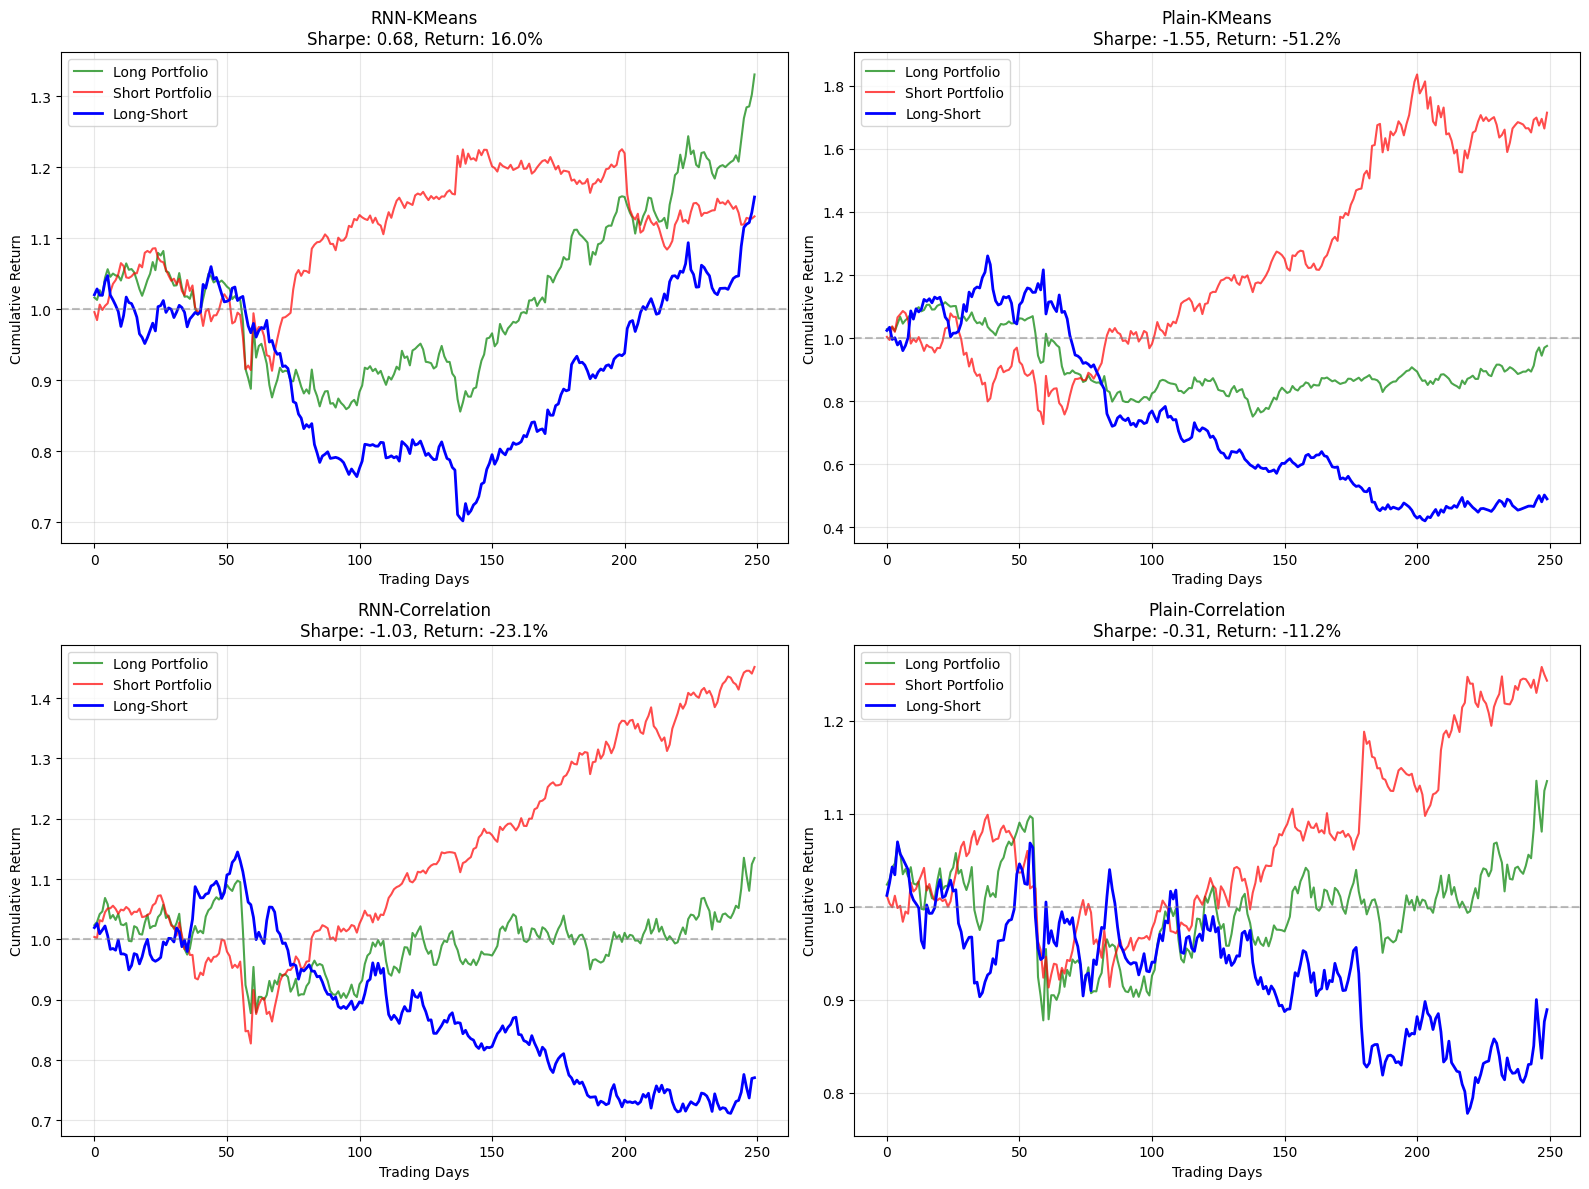


Cumulative returns saved to 'long_short_cumulative.png'


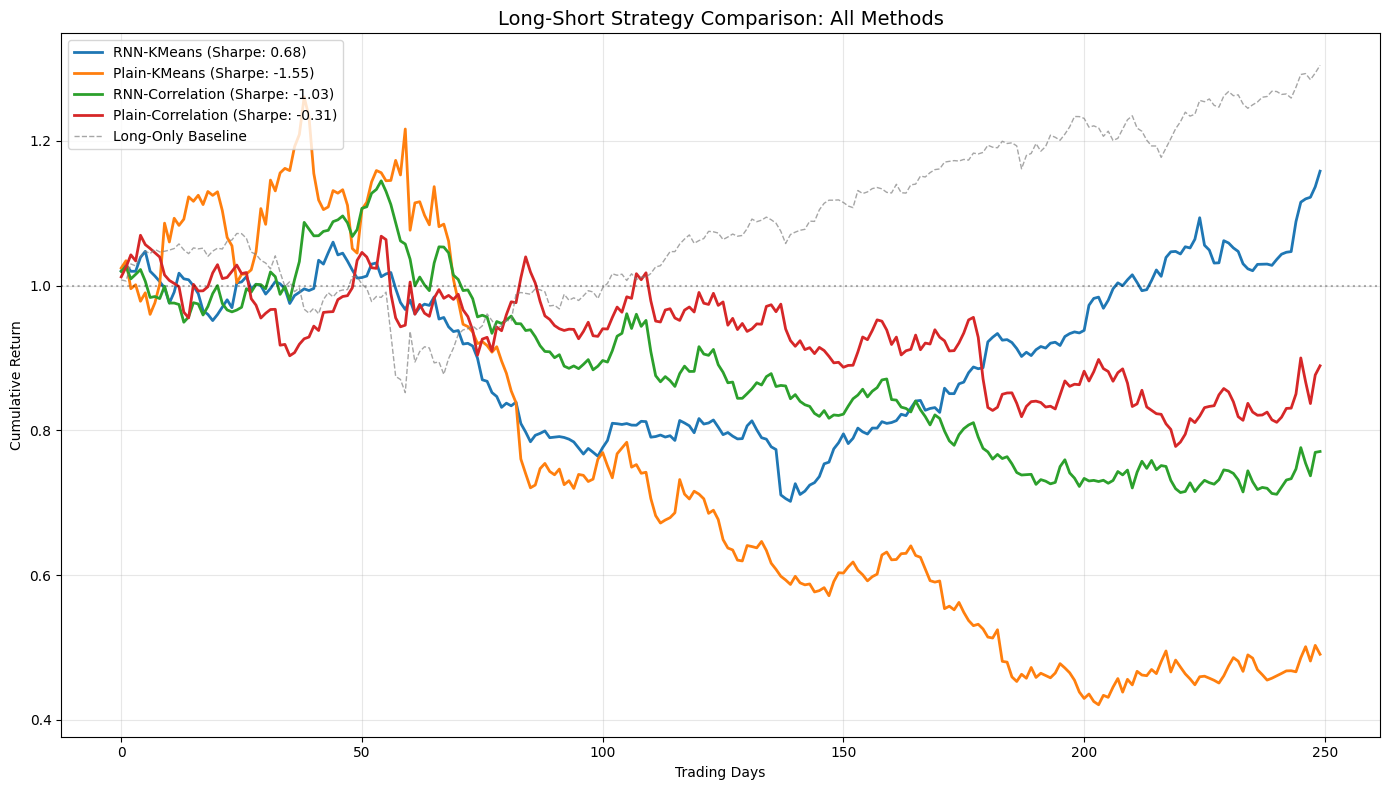

Strategy comparison saved to 'long_short_comparison.png'


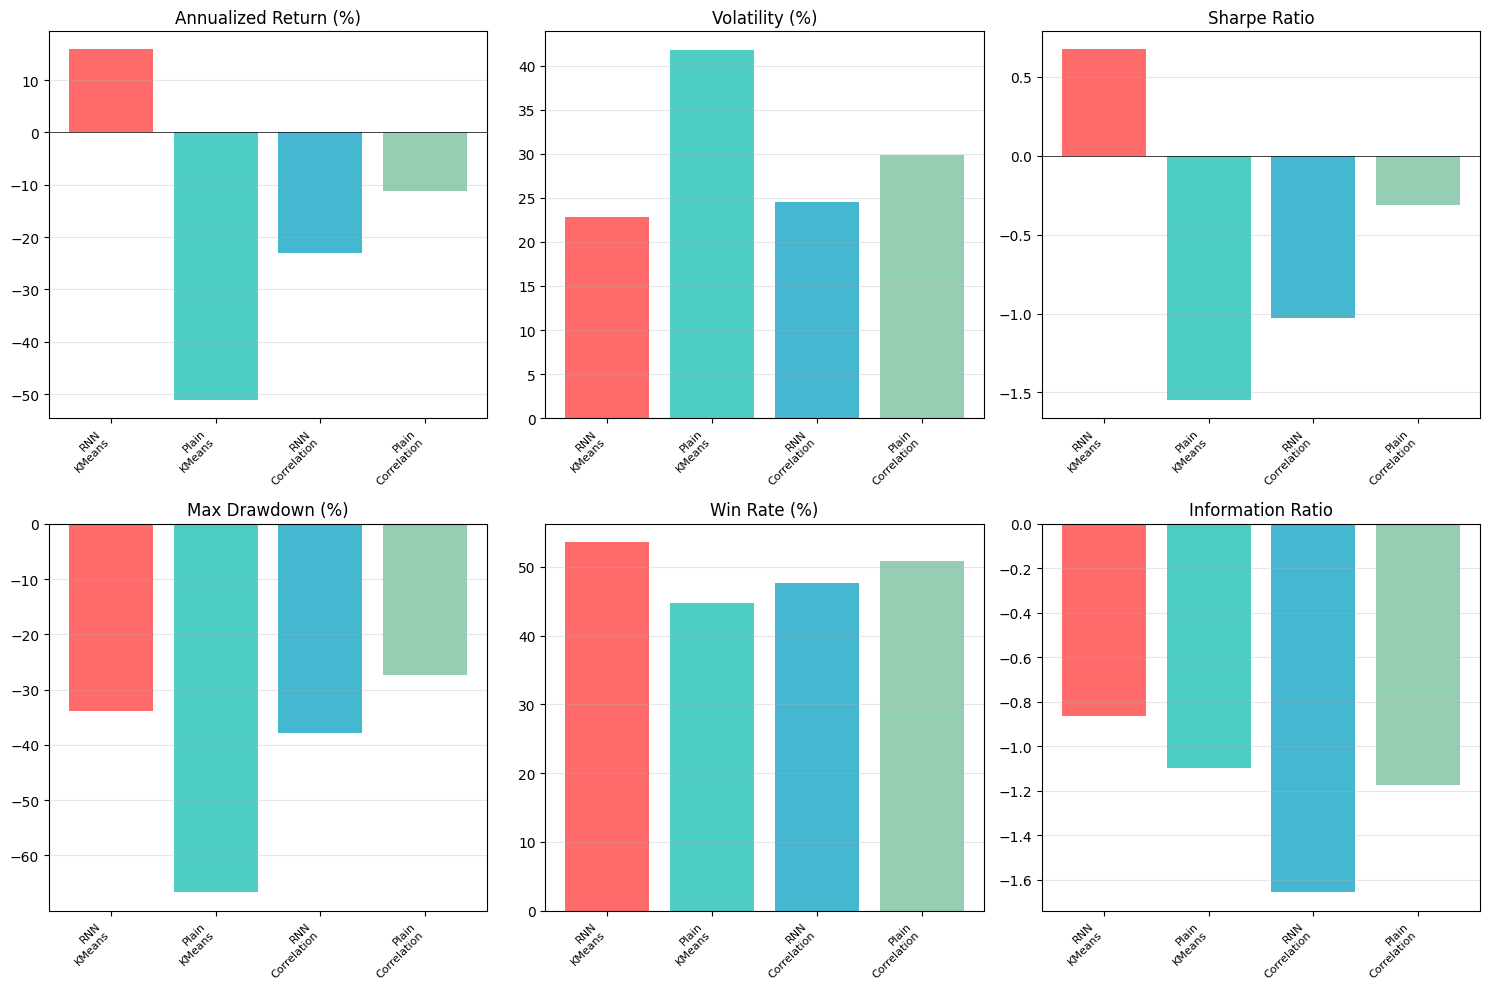

Metrics comparison saved to 'long_short_metrics.png'

SUMMARY

Long-Short Strategy Results:
----------------------------
• Best Sharpe Ratio: RNN-KMeans
  → Sharpe: 0.677

• Best Annualized Return: RNN-KMeans
  → Return: 15.96%

• Lowest Volatility: RNN-KMeans
  → Vol: 22.79%

• Best Win Rate: RNN-KMeans
  → Win Rate: 53.6%

Strategy Logic:
---------------
• Long the cluster with highest momentum → Bet on winners continuing
• Short the cluster with lowest momentum → Bet on losers continuing to lose
• Different clustering methods identify different "winner" and "loser" groups
• RNN-based methods may capture more complex patterns than plain methods

Comparison vs Long-Only Baseline:

  RNN-KMeans:
    Sharpe vs Baseline: -0.662
    Return vs Baseline: -14.78%
  Plain-KMeans:
    Sharpe vs Baseline: -2.889
    Return vs Baseline: -81.96%
  RNN-Correlation:
    Sharpe vs Baseline: -2.368
    Return vs Baseline: -53.81%
  Plain-Correlation:
    Sharpe vs Baseline: -1.651
    Return vs Basel

In [28]:
# =============================================================================
# 8. Results Comparison Table
# =============================================================================
print("\n" + "-"*100)
print(f"{'Method':<20} | {'Return':<10} | {'Vol':<10} | {'Sharpe':<10} | {'MaxDD':<10} | {'WinRate':<10} | {'L/S':<10}")
print("-"*100)

for method, metrics in results.items():
    ls_info = f"{metrics.get('Num Long', '-')}/{metrics.get('Num Short', '-')}"
    print(f"{method:<20} | {metrics['Annualized Return']*100:>8.2f}% | "
          f"{metrics['Volatility']*100:>8.2f}% | {metrics['Sharpe Ratio']:>8.3f} | "
          f"{metrics['Max Drawdown']*100:>8.2f}% | {metrics['Win Rate']*100:>8.1f}% | "
          f"{ls_info:<10}")
print("-"*100)

# =============================================================================
# 9. Rankings
# =============================================================================
print("\n" + "="*70)
print("RANKINGS BY METRIC")
print("="*70)

method_names = [m for m in results.keys() if 'Baseline' not in m]

rankings = {
    'Sharpe Ratio (↑)': sorted(method_names, key=lambda m: results[m]['Sharpe Ratio'], reverse=True),
    'Annualized Return (↑)': sorted(method_names, key=lambda m: results[m]['Annualized Return'], reverse=True),
    'Volatility (↓)': sorted(method_names, key=lambda m: results[m]['Volatility']),
    'Max Drawdown (↓)': sorted(method_names, key=lambda m: results[m]['Max Drawdown'], reverse=True),
    'Win Rate (↑)': sorted(method_names, key=lambda m: results[m]['Win Rate'], reverse=True),
}

for metric, ranking in rankings.items():
    print(f"\n{metric}:")
    for i, method in enumerate(ranking, 1):
        print(f"  {i}. {method}")

# =============================================================================
# 10. Visualization: Cumulative Returns
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = {'RNN-KMeans': '#FF6B6B', 'Plain-KMeans': '#4ECDC4',
          'RNN-Correlation': '#45B7D1', 'Plain-Correlation': '#96CEB4'}

for idx, (method, metrics) in enumerate([(m, results[m]) for m in method_names]):
    ax = axes[idx // 2, idx % 2]

    # Plot Long, Short, and Long-Short cumulative returns
    ax.plot(metrics['Long Cumulative'], label='Long Portfolio', color='green', alpha=0.7)
    ax.plot(metrics['Short Cumulative'], label='Short Portfolio', color='red', alpha=0.7)
    ax.plot(metrics['LS Cumulative'], label='Long-Short', color='blue', linewidth=2)
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)

    ax.set_title(f'{method}\nSharpe: {metrics["Sharpe Ratio"]:.2f}, Return: {metrics["Annualized Return"]*100:.1f}%')
    ax.set_xlabel('Trading Days')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('long_short_cumulative.png', dpi=150)
plt.show()
print("\nCumulative returns saved to 'long_short_cumulative.png'")

# =============================================================================
# 11. Visualization: All Long-Short Strategies Comparison
# =============================================================================
plt.figure(figsize=(14, 8))

for method in method_names:
    metrics = results[method]
    label = f"{method} (Sharpe: {metrics['Sharpe Ratio']:.2f})"
    plt.plot(metrics['LS Cumulative'], label=label, linewidth=2)

# Add baseline
plt.plot(results['Long-Only (Baseline)']['LS Cumulative'],
         label='Long-Only Baseline', linewidth=1, linestyle='--', color='gray', alpha=0.7)
plt.axhline(y=1, color='black', linestyle=':', alpha=0.3)

plt.title('Long-Short Strategy Comparison: All Methods', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('long_short_comparison.png', dpi=150)
plt.show()
print("Strategy comparison saved to 'long_short_comparison.png'")

# =============================================================================
# 12. Visualization: Metrics Bar Charts
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = [
    ('Annualized Return', 'Annualized Return (%)', lambda x: x * 100),
    ('Volatility', 'Volatility (%)', lambda x: x * 100),
    ('Sharpe Ratio', 'Sharpe Ratio', lambda x: x),
    ('Max Drawdown', 'Max Drawdown (%)', lambda x: x * 100),
    ('Win Rate', 'Win Rate (%)', lambda x: x * 100),
    ('Information Ratio', 'Information Ratio', lambda x: x),
]

method_labels = method_names
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, (metric_key, title, transform) in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = [transform(results[m][metric_key]) for m in method_labels]
    bars = ax.bar(range(len(method_labels)), values, color=colors_bar)
    ax.set_xticks(range(len(method_labels)))
    ax.set_xticklabels([m.replace('-', '\n') for m in method_labels], fontsize=8, rotation=45, ha='right')
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('long_short_metrics.png', dpi=150)
plt.show()
print("Metrics comparison saved to 'long_short_metrics.png'")

# =============================================================================
# 13. Summary
# =============================================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

best_sharpe_method = max(method_names, key=lambda m: results[m]['Sharpe Ratio'])
best_return_method = max(method_names, key=lambda m: results[m]['Annualized Return'])
lowest_vol_method = min(method_names, key=lambda m: results[m]['Volatility'])
best_winrate_method = max(method_names, key=lambda m: results[m]['Win Rate'])

print(f"""
Long-Short Strategy Results:
----------------------------
• Best Sharpe Ratio: {best_sharpe_method}
  → Sharpe: {results[best_sharpe_method]['Sharpe Ratio']:.3f}

• Best Annualized Return: {best_return_method}
  → Return: {results[best_return_method]['Annualized Return']*100:.2f}%

• Lowest Volatility: {lowest_vol_method}
  → Vol: {results[lowest_vol_method]['Volatility']*100:.2f}%

• Best Win Rate: {best_winrate_method}
  → Win Rate: {results[best_winrate_method]['Win Rate']*100:.1f}%

Strategy Logic:
---------------
• Long the cluster with highest momentum → Bet on winners continuing
• Short the cluster with lowest momentum → Bet on losers continuing to lose
• Different clustering methods identify different "winner" and "loser" groups
• RNN-based methods may capture more complex patterns than plain methods

Comparison vs Long-Only Baseline:
""")

baseline_sharpe = results['Long-Only (Baseline)']['Sharpe Ratio']
baseline_return = results['Long-Only (Baseline)']['Annualized Return']

for method in method_names:
    m = results[method]
    sharpe_diff = m['Sharpe Ratio'] - baseline_sharpe
    return_diff = m['Annualized Return'] - baseline_return
    print(f"  {method}:")
    print(f"    Sharpe vs Baseline: {'+' if sharpe_diff >= 0 else ''}{sharpe_diff:.3f}")
    print(f"    Return vs Baseline: {'+' if return_diff >= 0 else ''}{return_diff*100:.2f}%")

print("\n" + "="*70)
print("END OF ANALYSIS")
print("="*70)
